# Final Compliation - Ouray County Parcel Risk
**Author:** Bryce A Young  
**Institution**: University of Montana, National Center for Landscape Fire Analysis

**Created:** 2025-03-11 | 
**Modified:** 2025-03-13  

#### Overview
This notebook shows the salient points of predictions, clustering, and analysis for the Ouray Parcel Risk project. Consider this the highlight reel of the analysis folder in this repository.

This notebook compiles code from `risk_pred.ipynb`, `clustering.ipynb` and `structure_archetypes.ipynb`. Data from those notebooks is used in the present notebook and cleaned further. 

Final figures are produced and exported for presentations and for use in Chapters 2 and 3 of my masters thesis (risk score predictions and structure archetypes).

## Environment Setup
---

In [1]:
# setup environment
import os
### Directory ###
# Repository
os.chdir(r'D:/_PROJECTS/P001_OurayParcel/ouray')
# Root workspace
ws = r'D:/_PROJECTS/P001_OurayParcel'

### Data paths ###
# Folder where all the data inputs and outputs will live
data = os.path.join(ws, 'data')
# Scratch folder for intermediate files
scratch = os.path.join(data, '_temp')
# Any final outputs go here
out = os.path.join(data, '_out')
# Figures to export
figs = os.path.join(out, 'figures')

# correct working directory
os.getcwd()

'D:\\_PROJECTS\\P001_OurayParcel\\ouray'

## Risk Rating Predictions
---
In this section, I use a random forest classifier to make risk rating predictions. Here is the general workflow:
1. Import the most recent data containing reclassified features.
2. Re-do some of the one-hot encoding to make sure that the most important features are kept e.g. WUI class 1, wood roof
3. Select predictive categorical columns for minimal noise, along with the target columns 'Risk_Rating' and 'Risk_Rating_new'
4. Segment training and testing data
5. Run the random forest classifier and analyze the results

#### **1** Import data

In [2]:
import pandas as pd

pd.set_option('display.max_columns', None)

full_df = pd.read_csv(os.path.join(out, 'df_feat_clusters.csv'))
full_df.columns


Index(['Unnamed: 0', 'rwra_index', 'feat_index', 'parcel_num', 'Year',
       'address', 'ParcelNum', 'Model', 'Address_Visible',
       'Driveway_Clearance', 'Driveway_Lenth', 'Dist_to_Danger_Topo',
       'Slope_Final', 'Background_Fuels', 'Defensible_Space',
       'Roofing_Material', 'Building_Exterior', 'Other_Combustibles',
       'Decks_and_Fencing', 'Proximity_to_Neighboring_Home', 'Ingress_Egress',
       'Score_Final', 'Risk_Rating', 'County', 'wui_class', 'min_ssd',
       'mean_cc0_2m', 'mean_cc2_4m', 'mean_cc4_8m', 'mean_cc8_40m',
       'intersections', 'PARCELNB', 'ACCOUNT', 'ACRES_calc', 'hiz_ext_out',
       'tax_AIRC', 'tax_ARCH', 'tax_SQFT', 'tax_COND', 'tax_EYB',
       'tax_EXW_PERCENT', 'tax_EXW', 'tax_FLR', 'tax_FRME', 'tax_HTFL',
       'tax_INT', 'tax_RMS', 'tax_RCVR', 'tax_RSTR', 'Type', 'sum_cc',
       'tax_WBL', 'tax_DGR', 'tax_PTO', 'tax_OPP', 'Risk_Rating_new',
       'At_Least_8_Unobserved', 'wui_class_3', 'wui_class_5', 'wui_class_6',
       'tax_ARCH_C

#### **2** One-Hot Encoding

In [3]:
from sklearn.preprocessing import OneHotEncoder
# Initialize OHE
ohe = OneHotEncoder(sparse_output=False) 

# OHE cols
ohe_cols = ['wui_class', 'tax_EXW', 'tax_RCVR', 'tax_RSTR']
ohe_array = ohe.fit_transform(full_df[ohe_cols])
ohe_df = pd.DataFrame(ohe_array, columns=ohe.get_feature_names_out(ohe_cols))

ohe_df.head()


,wui_class_1,wui_class_3,wui_class_5,wui_class_6,tax_EXW_CONC/MSNRY,tax_EXW_MANFCTD,tax_EXW_WOOD,tax_RCVR_ASPHALT,tax_RCVR_METAL,tax_RCVR_OTHER,tax_RCVR_TILE,tax_RCVR_WOOD,tax_RSTR_GABLE,tax_RSTR_MANSARD,tax_RSTR_MULTI_PEAK,tax_RSTR_OTHER,tax_RSTR_SHED
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Now we have `full_df` and `ohe_df`. Let's clean up both dataframes, selecting only the columns that we want. We will drop the ohe cols from the original full_df and replace them with the selected ones from ohe_df when we concatenate the two dfs. 

In [5]:
# Drop all OHE cols from the original df
full_df = full_df.drop(columns=['wui_class_3', 'wui_class_5', 'wui_class_6',
       'tax_ARCH_COMMERCIAL', 'tax_ARCH_CUSTOM', 'tax_ARCH_LOG',
       'tax_ARCH_MANUFACTURED', 'tax_ARCH_MULTI FAMILY',
       'tax_ARCH_MULTI STORY', 'tax_ARCH_SINGLE STORY', 'tax_EXW_MANFCTD',
       'tax_EXW_WOOD', 'tax_RCVR_METAL', 'tax_RCVR_OTHER', 'tax_RCVR_TILE',
       'tax_RCVR_WOOD', 'tax_RSTR_MANSARD', 'tax_RSTR_MULTI_PEAK',
       'tax_RSTR_OTHER', 'tax_RSTR_SHED'])

# Gable includes hip as well, so we'll rename the column accordingly
full_df = full_df.rename(columns={'tax_RSTR_GABLE': 'tax_RSTR_HIP_GABLE'})

# Drop noisy OHE cols from new OHE df - keeping EXW masonry and wood, RCVR wood, RSTR hip/gable and multipeak, and all wui classes
ohe_df = ohe_df.drop(columns=['tax_EXW_MANFCTD', 'tax_RCVR_ASPHALT', 'tax_RCVR_METAL', 'tax_RCVR_OTHER', 'tax_RCVR_TILE',
                              'tax_RSTR_MANSARD', 'tax_RSTR_OTHER', 'tax_RSTR_SHED'])

df = pd.concat([full_df, ohe_df], axis=1)

df.head()

,Unnamed: 0,rwra_index,feat_index,parcel_num,Year,address,ParcelNum,Model,Address_Visible,Driveway_Clearance,Driveway_Lenth,Dist_to_Danger_Topo,Slope_Final,Background_Fuels,Defensible_Space,Roofing_Material,Building_Exterior,Other_Combustibles,Decks_and_Fencing,Proximity_to_Neighboring_Home,Ingress_Egress,Score_Final,Risk_Rating,County,wui_class,min_ssd,mean_cc0_2m,mean_cc2_4m,mean_cc4_8m,mean_cc8_40m,intersections,PARCELNB,ACCOUNT,ACRES_calc,hiz_ext_out,tax_AIRC,tax_ARCH,tax_SQFT,tax_COND,tax_EYB,tax_EXW_PERCENT,tax_EXW,tax_FLR,tax_FRME,tax_HTFL,tax_INT,tax_RMS,tax_RCVR,tax_RSTR,Type,sum_cc,tax_WBL,tax_DGR,tax_PTO,tax_OPP,Risk_Rating_new,At_Least_8_Unobserved,fc2m,fc4m,fc8m,fc8m+,intsc_class,acre_class,sqft_class,ssd_class,eyb_class,cluster_spc12,cluster_spc10,cluster_dbscan,wui_class_1,wui_class_3,wui_class_5,wui_class_6,tax_EXW_CONC/MSNRY,tax_EXW_WOOD,tax_RCVR_WOOD,tax_RSTR_GABLE,tax_RSTR_MULTI_PEAK
0,4,5.0,921.0,4.039351e+11,2017.0,416 COUNTY ROAD 22A,4.039351e+11,B,5.0,0.0,11.0,0.0,0.0,10.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,76.0,Low,Ouray County,1,211.505051,0.048738,0.084885,0.034318,0.00000,0.0,4.039351e+11,R000531,32.728300,False,1 - NONE,SINGLE STORY,4034.9,3 - GOOD,2015.0,100.0,CONC/MSNRY,WDJST,WOOD,GAS,DRYWALL,0.776148,ASPHALT,GABLE,Residence,0.167940,1.0,1.0,3.0,3.0,Low,False,2,3,1,0,0,5,3,3,5,0,0,2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,5,6.0,509.0,4.039264e+11,2017.0,3100 COUNTY ROAD 22,4.039264e+11,B,15.0,0.0,11.0,0.0,0.0,10.0,0.0,0.0,0.0,80.0,0.0,0.0,0.0,116.0,Low,Ouray County,3,180.054332,0.023967,0.015273,0.000271,0.00004,0.0,4.039264e+11,R005599,9.707660,False,1 - NONE,MULTI STORY,1942.0,2 - VERY GOOD,2010.0,100.0,CONC/MSNRY,WDJST,WOOD,GAS,DRYWALL,0.776148,METAL,GABLE,Residence,0.039551,2.0,1.0,1.0,2.0,Low,False,1,1,1,1,0,4,2,3,4,1,3,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,6,7.0,1296.0,4.039263e+11,2017.0,3245 COUNTY ROAD 22,4.039263e+11,B,0.0,0.0,11.0,0.0,0.0,20.0,50.0,0.0,0.0,0.0,0.0,100.0,0.0,181.0,Low,Ouray County,1,5.979973,0.032157,0.101354,0.136954,0.00000,1.0,4.039263e+11,R004277,0.822618,True,1 - NONE,COMMERCIAL,1579.0,4 - AVERAGE,2000.0,100.0,MANFCTD,CONC/MSNRY,WOOD,STOVE,DRYWALL,0.000000,METAL,MANSARD,Commercial,0.270465,1.0,1.0,1.0,1.0,Low,False,1,3,3,0,1,1,2,1,3,6,1,-1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7,8.0,727.0,4.039363e+11,2017.0,4452 COUNTY ROAD 1,4.039363e+11,B,5.0,5.0,11.0,0.0,0.0,10.0,0.0,0.0,70.0,0.0,100.0,50.0,0.0,251.0,Moderate,Ouray County,3,20.479874,0.025695,0.047097,0.039426,0.00012,1.0,4.039363e+11,R004198,38.439600,False,1 - NONE,MULTI STORY,2865.0,3 - GOOD,2000.0,100.0,WOOD,WDJST,WOOD,STOVE,DRYWALL,0.000000,METAL,GABLE,Residence,0.112337,1.0,1.0,1.0,1.0,Moderate,False,1,2,1,1,1,5,2,2,3,9,0,5,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,8,9.0,1332.0,4.039352e+11,2017.0,3479 COUNTY ROAD 22,4.039352e+11,B,5.0,5.0,11.0,0.0,0.0,10.0,0.0,0.0,70.0,80.0,0.0,0.0,0.0,181.0,Low,Ouray County,5,100.486083,0.018661,0.045186,0.068360,0.00000,0.0,4.039352e+11,R004237,12.296800,True,1 - NONE,MULTI STORY,1696.0,3 - GOOD,2000.0,100.0,WOOD,WDJST,WOOD,ELECTRIC,DRYWALL,0.000000,ASPHALT,GABLE,Residence,0.132208,1.0,1.0,1.0,2.0,Low,False,1,2,2,0,0,5,2,3,3,2,4,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [6]:
df.columns

Index(['Unnamed: 0', 'rwra_index', 'feat_index', 'parcel_num', 'Year',
       'address', 'ParcelNum', 'Model', 'Address_Visible',
       'Driveway_Clearance', 'Driveway_Lenth', 'Dist_to_Danger_Topo',
       'Slope_Final', 'Background_Fuels', 'Defensible_Space',
       'Roofing_Material', 'Building_Exterior', 'Other_Combustibles',
       'Decks_and_Fencing', 'Proximity_to_Neighboring_Home', 'Ingress_Egress',
       'Score_Final', 'Risk_Rating', 'County', 'wui_class', 'min_ssd',
       'mean_cc0_2m', 'mean_cc2_4m', 'mean_cc4_8m', 'mean_cc8_40m',
       'intersections', 'PARCELNB', 'ACCOUNT', 'ACRES_calc', 'hiz_ext_out',
       'tax_AIRC', 'tax_ARCH', 'tax_SQFT', 'tax_COND', 'tax_EYB',
       'tax_EXW_PERCENT', 'tax_EXW', 'tax_FLR', 'tax_FRME', 'tax_HTFL',
       'tax_INT', 'tax_RMS', 'tax_RCVR', 'tax_RSTR', 'Type', 'sum_cc',
       'tax_WBL', 'tax_DGR', 'tax_PTO', 'tax_OPP', 'Risk_Rating_new',
       'At_Least_8_Unobserved', 'fc2m', 'fc4m', 'fc8m', 'fc8m+', 'intsc_class',
       'acre_cl

#### **3** Select salient features

In [8]:
# Define predictive columns (and include target variable)
rf_pred_cols = ['Risk_Rating', 'Risk_Rating_new', 'tax_WBL', 'tax_DGR', 'tax_PTO', 'tax_OPP', 
       'fc2m', 'fc4m', 'fc8m', 'fc8m+', 'intsc_class',
       'acre_class', 'sqft_class', 'ssd_class', 'eyb_class',
       'wui_class_1', 'wui_class_3',
       'wui_class_5', 'wui_class_6', 'tax_EXW_CONC/MSNRY', 'tax_EXW_WOOD',
       'tax_RCVR_WOOD', 'tax_RSTR_GABLE', 'tax_RSTR_MULTI_PEAK']

# Create dataframe from predictive columns
pred = df[rf_pred_cols]

pred.head(20)

,Risk_Rating,Risk_Rating_new,tax_WBL,tax_DGR,tax_PTO,tax_OPP,fc2m,fc4m,fc8m,fc8m+,intsc_class,acre_class,sqft_class,ssd_class,eyb_class,wui_class_1,wui_class_3,wui_class_5,wui_class_6,tax_EXW_CONC/MSNRY,tax_EXW_WOOD,tax_RCVR_WOOD,tax_RSTR_GABLE,tax_RSTR_MULTI_PEAK
0,Low,Low,1.0,1.0,3.0,3.0,2,3,1,0,0,5,3,3,5,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,Low,Low,2.0,1.0,1.0,2.0,1,1,1,1,0,4,2,3,4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,Low,Low,1.0,1.0,1.0,1.0,1,3,3,0,1,1,2,1,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Moderate,Moderate,1.0,1.0,1.0,1.0,1,2,1,1,1,5,2,2,3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,Low,Low,1.0,1.0,1.0,2.0,1,2,2,0,0,5,2,3,3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
5,Low,Moderate,3.0,1.0,1.0,2.0,1,2,2,0,0,5,3,3,4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6,Low,Low,1.0,1.0,3.0,2.0,3,3,1,1,0,5,2,3,4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,Low,Low,1.0,1.0,1.0,3.0,2,2,1,0,0,6,2,3,3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,Low,Moderate,1.0,1.0,1.0,3.0,2,3,1,0,1,5,1,1,3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
9,Low,Moderate,1.0,1.0,2.0,1.0,2,2,1,1,0,3,1,3,4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


#### **4** Train-Test Split

We will do a train-test split and run a rf classifier for both the original and reclassified risk ratings

In [46]:
from sklearn.model_selection import train_test_split

# Define train-test split function
def split_data(df):
    X = df.drop(columns=['Risk_Rating', 'Risk_Rating_new'])
    y = df['Risk_Rating_new']
    return train_test_split(X, y, test_size=0.2, random_state=42)

# Apply to categorical data
X_train, X_test, y_train, y_test = split_data(pred)

In [51]:
from sklearn.model_selection import train_test_split

# Define train-test split function
def split_data(df):
    X = df.drop(columns=['Risk_Rating', 'Risk_Rating_new'])
    y = df['Risk_Rating']
    return train_test_split(X, y, test_size=0.2, random_state=42)

# Apply to categorical data
X_train, X_test, y_train, y_test = split_data(pred)

#### **5** Random Forest Classifier
In this RF classifier, we elect for balanced class weights to reduce model bias as much as possible. We also generate shadow variables with bortua selection, which compares real features against shadow variables (randomly shuffled versions of the features) to determine their importance. It helps identify truly important features by ensuring they perform better than the noise.

In [47]:
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

# Initialize the classifier
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

In [52]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the classifier
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

#### **6** Analysis of Results

In [48]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.3f}")

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Classification Report (Precision, Recall, F1-Score)
print("Classification Report:\n", classification_report(y_test, y_pred, digits=3))

Accuracy: 0.677
Confusion Matrix:
 [[  5   0   0   6   0]
 [  1   3   0  35   0]
 [  0   0   4  36   0]
 [  4   3   1 177   0]
 [  0   0   1   3   0]]
Classification Report:
               precision    recall  f1-score   support

     Extreme      0.500     0.455     0.476        11
        High      0.500     0.077     0.133        39
         Low      0.667     0.100     0.174        40
    Moderate      0.689     0.957     0.801       185
   Very High      0.000     0.000     0.000         4

    accuracy                          0.677       279
   macro avg      0.471     0.318     0.317       279
weighted avg      0.642     0.677     0.593       279



d:\venv\python\parcel\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\venv\python\parcel\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\venv\python\parcel\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [53]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.3f}")

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Classification Report (Precision, Recall, F1-Score)
print("Classification Report:\n", classification_report(y_test, y_pred, digits=3))

Accuracy: 0.545
Confusion Matrix:
 [[ 7 11  0  0  0]
 [ 7 96  6 13  2]
 [ 0 25 37  7  0]
 [ 3 33 10 12  0]
 [ 1  8  0  1  0]]
Classification Report:
               precision    recall  f1-score   support

     Extreme      0.389     0.389     0.389        18
        High      0.555     0.774     0.646       124
         Low      0.698     0.536     0.607        69
    Moderate      0.364     0.207     0.264        58
   Very High      0.000     0.000     0.000        10

    accuracy                          0.545       279
   macro avg      0.401     0.381     0.381       279
weighted avg      0.520     0.545     0.517       279



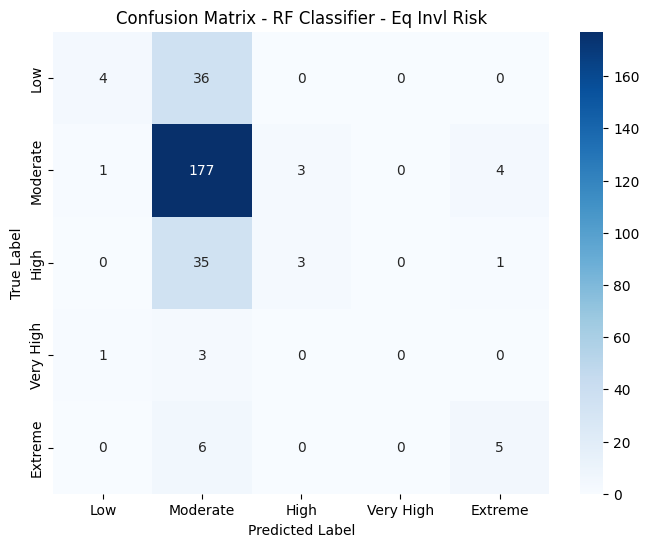

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
classes = ['Low', 'Moderate', 'High', 'Very High', 'Extreme']  # Get class labels
cm = confusion_matrix(y_test, y_pred, labels=classes)


# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - RF Classifier - Eq Invl Risk')
plt.show()

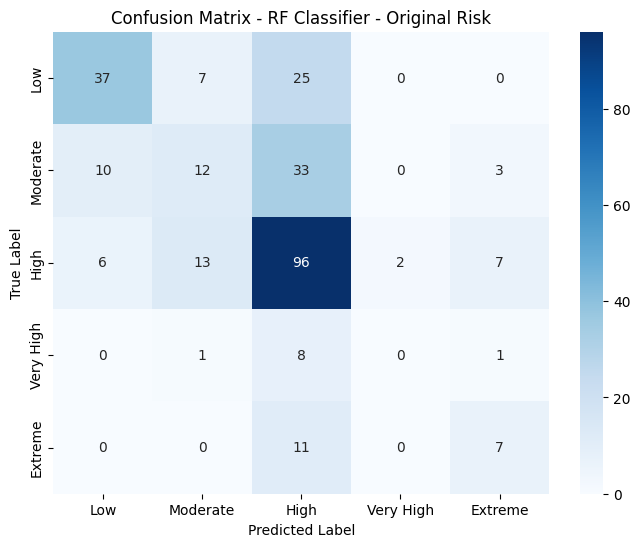

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
classes = ['Low', 'Moderate', 'High', 'Very High', 'Extreme']  # Get class labels
cm = confusion_matrix(y_test, y_pred, labels=classes)


# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - RF Classifier - Original Risk')
plt.show()

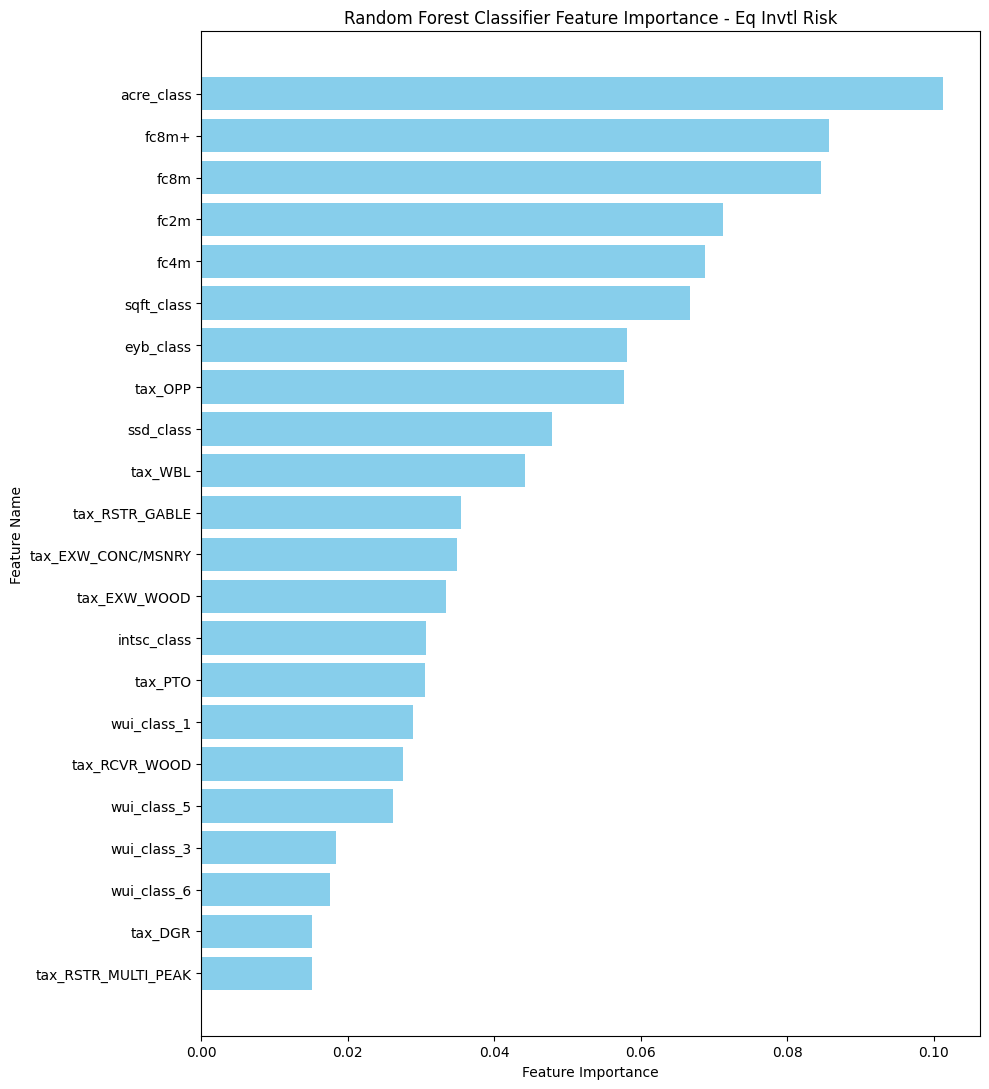

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importances
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': clf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, min(12, 0.5 * len(feature_importances))))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Random Forest Classifier Feature Importance - Eq Invtl Risk')
plt.tight_layout()
plt.gca().invert_yaxis()  # Highest at top
plt.show()

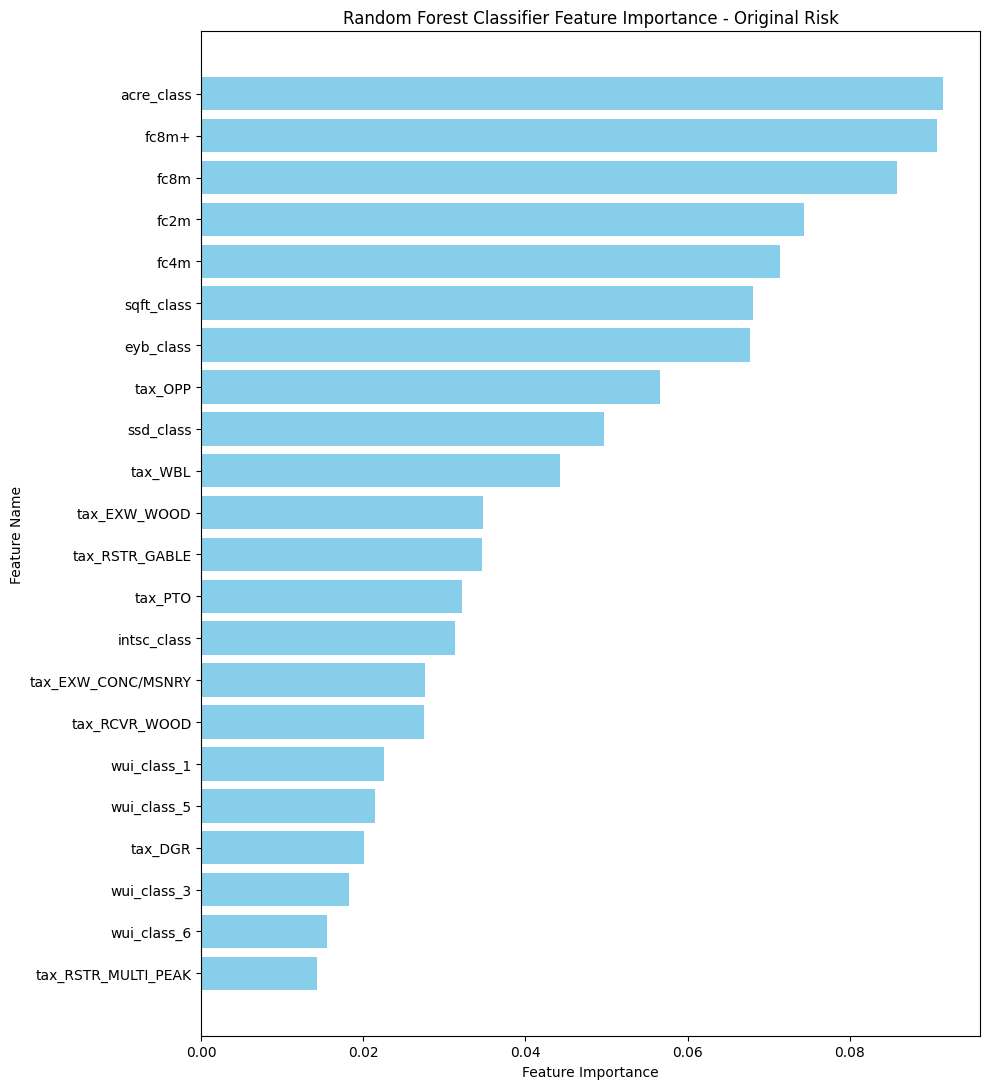

In [55]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importances
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': clf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, min(12, 0.5 * len(feature_importances))))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Random Forest Classifier Feature Importance - Original Risk')
plt.tight_layout()
plt.gca().invert_yaxis()  # Highest at top
plt.show()

#### **7** Conclusions
**Feature Importance**  
Using the rf classifier on what we refer to here as original risk and equal interval risk, the 10 most important features were common across both models. In order, these features are:
1. acre_class: the size of the property
2. fc8m+: mean fuel cover taller than 8m in defensible space
3. fc8m: mean fuel cover 4-8m in defensible space
4. fc2m: mean fuel cover 0-2m in defensible space
5. fc4m: mean fuel cover 2-4m in defensible space
6. sqft_class: the size of the structure
7. eyb_class: the effective age of the structure
8. tax_OPP: the tax-assessed size of the structure's open-air porch space (correlated with structure sqft)
9. ssd_class: distance to nearest adjacent structure
10. tax_WBL: the tax-assessed size of the wood balcony (correlated with structure sqft)

**Model Performance**  
Rnadom forest classifer performed best on equal interval risk ratings, with an accuracy of 0.677. However, the model predicted most homes to be 'Moderate' risk since that is where most homes were classified. This unbalanced data is an unreliable indication of model performance. When we compare to predictions on Original risk rating (accuracy 0.545), we can see that equal interval risk outperformed the original risk classifications. 

**Issues with Predicting Risk Ratings**  
One issue with predicting risk ratings is that there are not equal breaks.
- 20 <= 'Low' <= 240 (range=220)
- 241 <= 'Moderate' <= 305 (range=64)
- 306 <= 'High' <= 435 (range=129)
- 436 <= 'Very High' <= 505 (range=69)
- 506 <= 'Extreme' <= 1000 (range=494)

Therefore, we reclassified risk ratings with equal interval breaks, each with a range of 200 points.
- 0 <= 'Low' <= 200
- 201 <= 'Moderate' <= 400
- 401 <= 'High' <= 600
- 601 <= 'Very High' <= 800
- 801 <= 'Extreme' <= 1000

The number of observations per risk rating (original and reclassified) is printed from the code block below.
  
*Original Classification of Extreme Risk and Unobserved Features*  
- 68 of 68 observations with at least 8 unobserved features have a 'Risk_Rating' (original classification) of 'Extreme'. That is 68 of 117 total 'Extreme' observations.  
- 81 of 85 observations where at least 6 features were unobserved have a 'Risk_Rating' (original classification) of 'Extreme'. That is 81 of 117 total 'Extreme' observations.  

*Reclassified Extreme Risk and Unobserved Features*  
- 60 of 63 'Extreme' values of 'Risk_Rating_new' (reclassified) have at least 8 unobserved features
- 62 of 63 'Extreme' values of 'Risk_Rating_new' (reclassified) have at least 6 unobserved features

**Additional Conclusions and Observations**  
- In the WiRe model, whether or not a roof is wood has the highest correlation with the final risk rating of the home. However, the presence of a wooden roof had low importance in both rf classifier models. 
- If a feature or set of features could not be observed in a drive-by assessment, they were given the highest risk score. This is commensurate with findings from Meldrum et al. 2022. It is also commensurate with the above finding that the size of the property was the largest predictor of risk - if a home is on a large property, it is presumably more difficult to observe.

In [56]:
# Print number of observations per risk rating
print(df['Risk_Rating'].value_counts())
print(df['Risk_Rating_new'].value_counts())

Risk_Rating
High         610
Moderate     312
Low          302
Extreme      115
Very High     53
Name: count, dtype: int64
Risk_Rating_new
Moderate     940
High         179
Low          175
Extreme       63
Very High     35
Name: count, dtype: int64


## Dimensionality Reduction and Clustering 
---
Here, we use t-distributed stochastic neighbor embedding (t-SNE) to reduce the dimensionality of the predictive data to two components. We then use spectral clustering to group the data into similar features and analyze the components of each cluster. 

In [117]:
# Define the tsne columns for reducing dimensionality
tsne_cols = X_train.columns.to_list()
for col in tsne_cols:
    value_counts = df[col].value_counts()  # Get counts per unique value
    print(f"\nFeature: {col}")
    print(value_counts.to_string())  # Print in a clean format




Feature: tax_WBL
tax_WBL
1.0    1049
3.0     207
2.0     136

Feature: tax_DGR
tax_DGR
1.0    1257
3.0      89
2.0      46

Feature: tax_PTO
tax_PTO
1.0    1067
3.0     308
2.0      17

Feature: tax_OPP
tax_OPP
3.0    731
1.0    425
2.0    236

Feature: fc2m
fc2m
1    558
2    523
3    256
4     52
5      3

Feature: fc4m
fc4m
3    536
4    342
2    284
1    223
5      6
0      1

Feature: fc8m
fc8m
3    406
4    389
2    254
1    252
5     88
0      3

Feature: fc8m+
fc8m+
1    597
3    218
4    189
2    181
0    180
5     27

Feature: intsc_class
intsc_class
0    787
1    571
2     34

Feature: acre_class
acre_class
5    436
2    355
3    184
1    170
4    159
6     71
7     17

Feature: sqft_class
sqft_class
2    735
3    329
1    264
4     64

Feature: ssd_class
ssd_class
3    820
2    360
1    212

Feature: eyb_class
eyb_class
4    805
3    398
5     95
2     75
1     19

Feature: wui_class_1
wui_class_1
1.0    820
0.0    572

Feature: wui_class_3
wui_class_3
0.0    1119
1.0     

In [61]:
print(f'there are {len(tsne_cols)} predictive features')
print(f'there are {len(df)} total structures')

there are 22 predictive features
there are 1392 total structures


#### **1** Reduce dimensionality with t-SNE

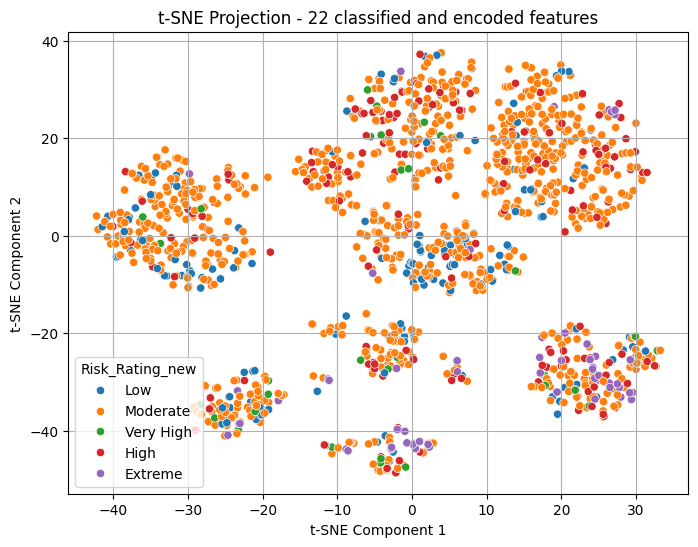

In [107]:
# Scale features
from sklearn.preprocessing import StandardScaler

# Select tsne_cols
X_final = df[tsne_cols]

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_final)

##################################
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Run t-SNE
tsne = TSNE(n_components=2, perplexity=40, max_iter=999, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Convert to DataFrame
df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])

# Visualize t-SNE
plt.figure(figsize=(8,6))
sns.scatterplot(x=df_tsne['TSNE1'], y=df_tsne['TSNE2'], hue=df['Risk_Rating_new'])
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Projection - 22 classified and encoded features")
plt.grid()
plt.show()

#### **2** Cluster with DBSCAN

In [77]:
from sklearn.cluster import DBSCAN
import numpy as np

# Define DBSCAN parameters
eps = 3.5  # Adjust based on your data
min_samples = 15  # Minimum points to form a dense cluster

# Run DBSCAN on t-SNE data
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
df['cluster_dbscan'] = dbscan.fit_predict(X_tsne)  # Assign clusters

# Print unique cluster labels
print(f"DBSCAN found {df['cluster_dbscan'].nunique()} clusters (including noise)")

DBSCAN found 9 clusters (including noise)


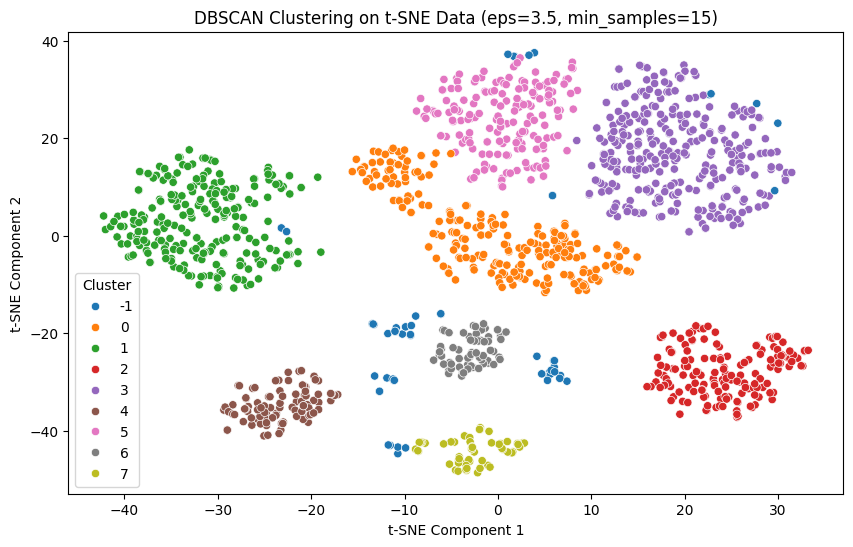

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=df['cluster_dbscan'], palette=sns.color_palette(n_colors=9))
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("DBSCAN Clustering on t-SNE Data (eps=3.5, min_samples=15)")
plt.legend(title="Cluster")
plt.show()

The majority of Extreme risk ratings are in clusters 2 and 7.

## Structure Archetypes
---
We have added the dbscan cluster assignments to the original dataframe and will now analyze these clusters according to the features that were used to create them. 

In [96]:
# Group by DBSCAN clusters and compute mean values for features
cluster_summary = df.groupby('cluster_dbscan')[tsne_cols].describe()
cluster_summary

tax_WBL                                               tax_DGR  \
                 count      mean       std  min  25%  50%   75%  max   count   
cluster_dbscan                                                                 
-1                55.0  1.727273  0.932034  1.0  1.0  1.0  3.00  3.0    55.0   
 0               228.0  1.403509  0.741701  1.0  1.0  1.0  1.25  3.0   228.0   
 1               247.0  1.202429  0.555382  1.0  1.0  1.0  1.00  3.0   247.0   
 2               158.0  1.537975  0.787126  1.0  1.0  1.0  2.00  3.0   158.0   
 3               310.0  1.529032  0.818948  1.0  1.0  1.0  2.00  3.0   310.0   
 4                93.0  1.182796  0.509608  1.0  1.0  1.0  1.00  3.0    93.0   
 5               181.0  1.187845  0.525004  1.0  1.0  1.0  1.00  3.0   181.0   
 6                65.0  1.584615  0.808013  1.0  1.0  1.0  2.00  3.0    65.0   
 7                55.0  1.545455  0.856742  1.0  1.0  1.0  2.00  3.0    55.0   

                                                            tax_PTO            \
                    mean       std  min  25%  50%  75%  max   count      mean   
cluster_dbscan                                                                  
-1              1.127273  0.473542  1.0  1.0  1.0  1.0  3.0    55.0  1.509091   
 0              1.469298  0.809593  1.0  1.0  1.0  2.0  3.0   228.0  1.535088   
 1              1.186235  0.546360  1.0  1.0  1.0  1.0  3.0   247.0  1.461538   
 2              1.259494  0.640266  1.0  1.0  1.0  1.0  3.0   158.0  1.398734   
 3              1.016129  0.126175  1.0  1.0  1.0  1.0  2.0   310.0  1.364516   
 4              1.139785  0.479841  1.0  1.0  1.0  1.0  3.0    93.0  1.365591   
 5              1.011050  0.104825  1.0  1.0  1.0  1.0  2.0   181.0  1.370166   
 6              1.046154  0.211451  1.0  1.0  1.0  1.0  2.0    65.0  1.830769   
 7              1.000000  0.000000  1.0  1.0  1.0  1.0  1.0    55.0  1.690909   

                                                  tax_OPP                      \
                     std  min  25%  50%  75%  max   count      mean       std   
cluster_dbscan                                                                  
-1              0.879241  1.0  1.0  1.0  2.0  3.0    55.0  2.054545  0.869614   
 0              0.877319  1.0  1.0  1.0  3.0  3.0   228.0  2.399123  0.792809   
 1              0.834677  1.0  1.0  1.0  1.0  3.0   247.0  2.214575  0.909810   
 2              0.797607  1.0  1.0  1.0  1.0  3.0   158.0  2.234177  0.918096   
 3              0.762829  1.0  1.0  1.0  1.0  3.0   310.0  2.125806  0.896042   
 4              0.777188  1.0  1.0  1.0  1.0  3.0    93.0  2.172043  0.867576   
 5              0.768111  1.0  1.0  1.0  1.0  3.0   181.0  1.988950  0.900549   
 6              0.993246  1.0  1.0  1.0  3.0  3.0    65.0  2.738462  0.619398   
 7              0.959798  1.0  1.0  1.0  3.0  3.0    55.0  2.381818  0.871162   

                                          fc2m                                \
                min  25%  50%  75%  max  count      mean       std  min  25%   
cluster_dbscan                                                                 
-1              1.0  1.0  2.0  3.0  3.0   55.0  1.836364  0.787956  1.0  1.0   
 0              1.0  2.0  3.0  3.0  3.0  228.0  1.815789  0.840241  1.0  1.0   
 1              1.0  1.0  3.0  3.0  3.0  247.0  1.635628  0.696117  1.0  1.0   
 2              1.0  1.0  3.0  3.0  3.0  158.0  2.031646  0.912900  1.0  1.0   
 3              1.0  1.0  2.0  3.0  3.0  310.0  1.916129  0.873596  1.0  1.0   
 4              1.0  1.0  2.0  3.0  3.0   93.0  1.892473  0.972026  1.0  1.0   
 5              1.0  1.0  2.0  3.0  3.0  181.0  2.066298  0.946351  1.0  1.0   
 6              1.0  3.0  3.0  3.0  3.0   65.0  1.892308  0.831472  1.0  1.0   
 7              1.0  1.5  3.0  3.0  3.0   55.0  1.600000  0.626572  1.0  1.0   

                                fc4m                                          \
                50%  75%  max  count      mean       std  min  25% 

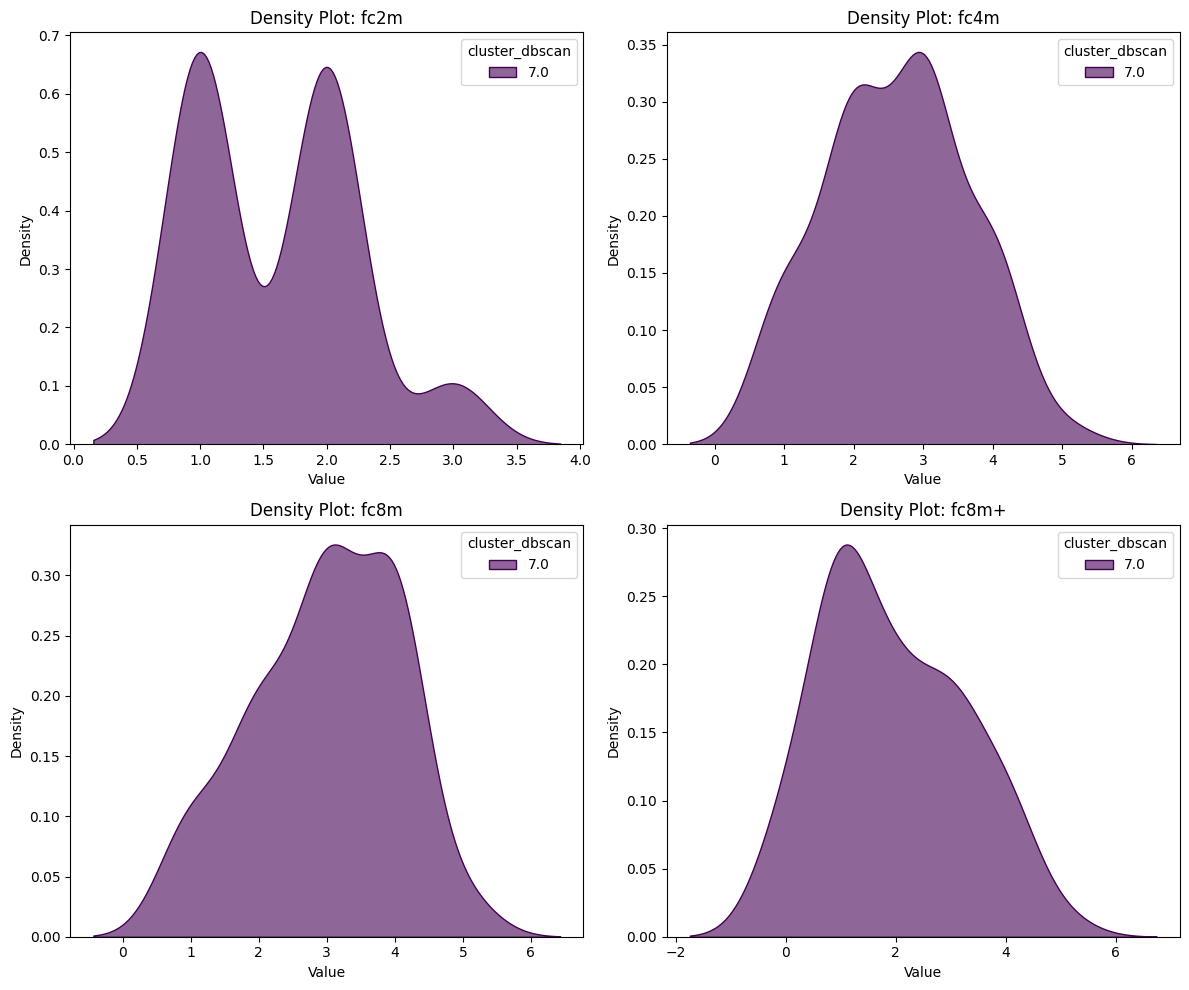

In [113]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define feature names and titles
features = ['fc2m', 'fc4m', 'fc8m', 'fc8m+']
titles = ['Density Plot: fc2m', 'Density Plot: fc4m', 'Density Plot: fc8m', 'Density Plot: fc8m+']

# Set up 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Flatten axes for easy looping
axes = axes.flatten()

# Loop through features and plot density
for i, feature in enumerate(features):
    sns.kdeplot(data=df[df['cluster_dbscan'] == 7], x=df[feature], hue='cluster_dbscan', fill=True, ax=axes[i], palette="viridis", alpha=0.6)
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Density")

# Adjust layout
plt.tight_layout()
plt.show()

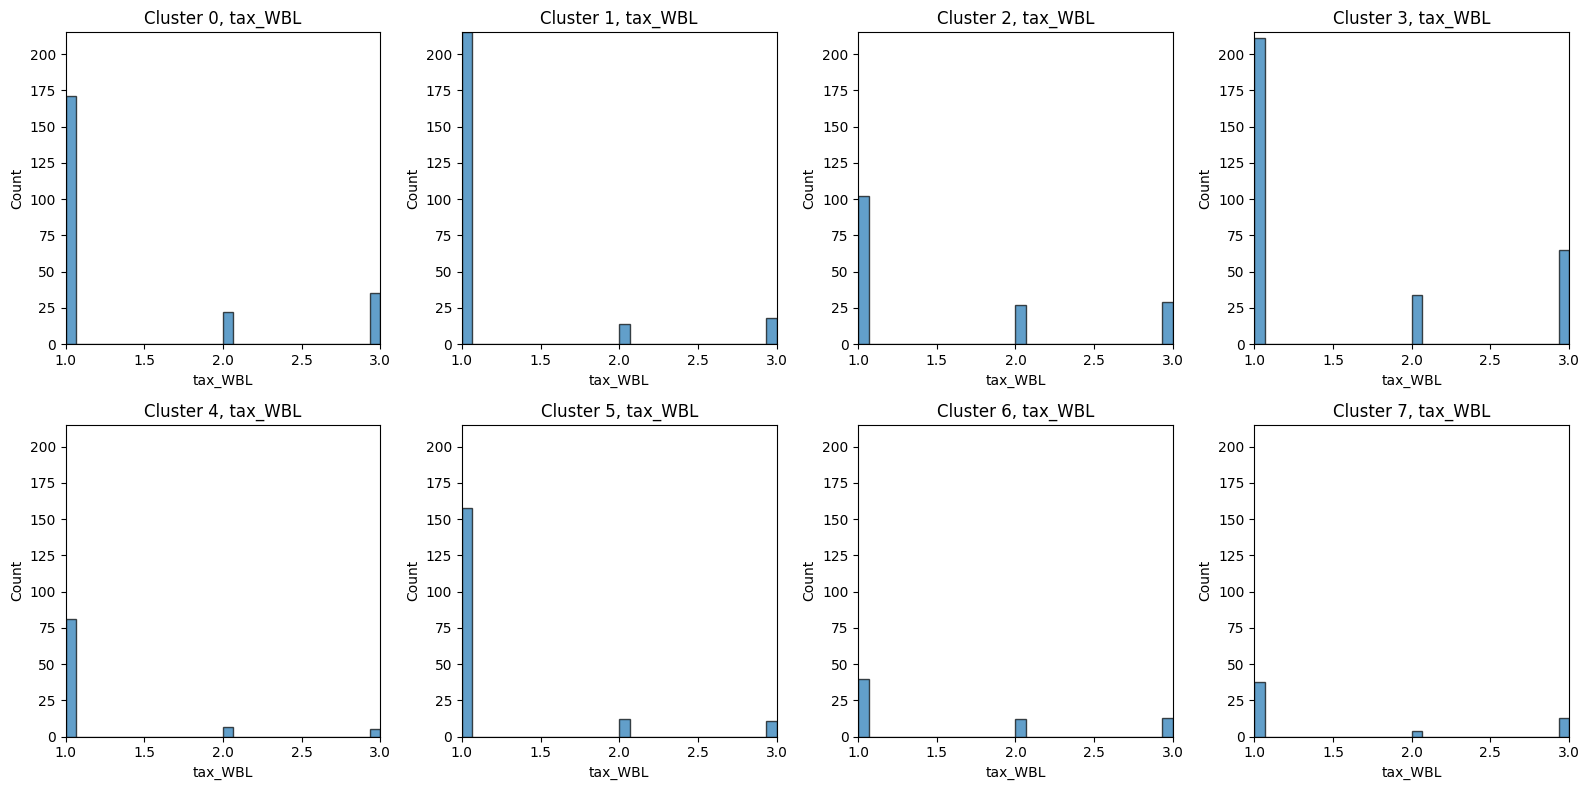

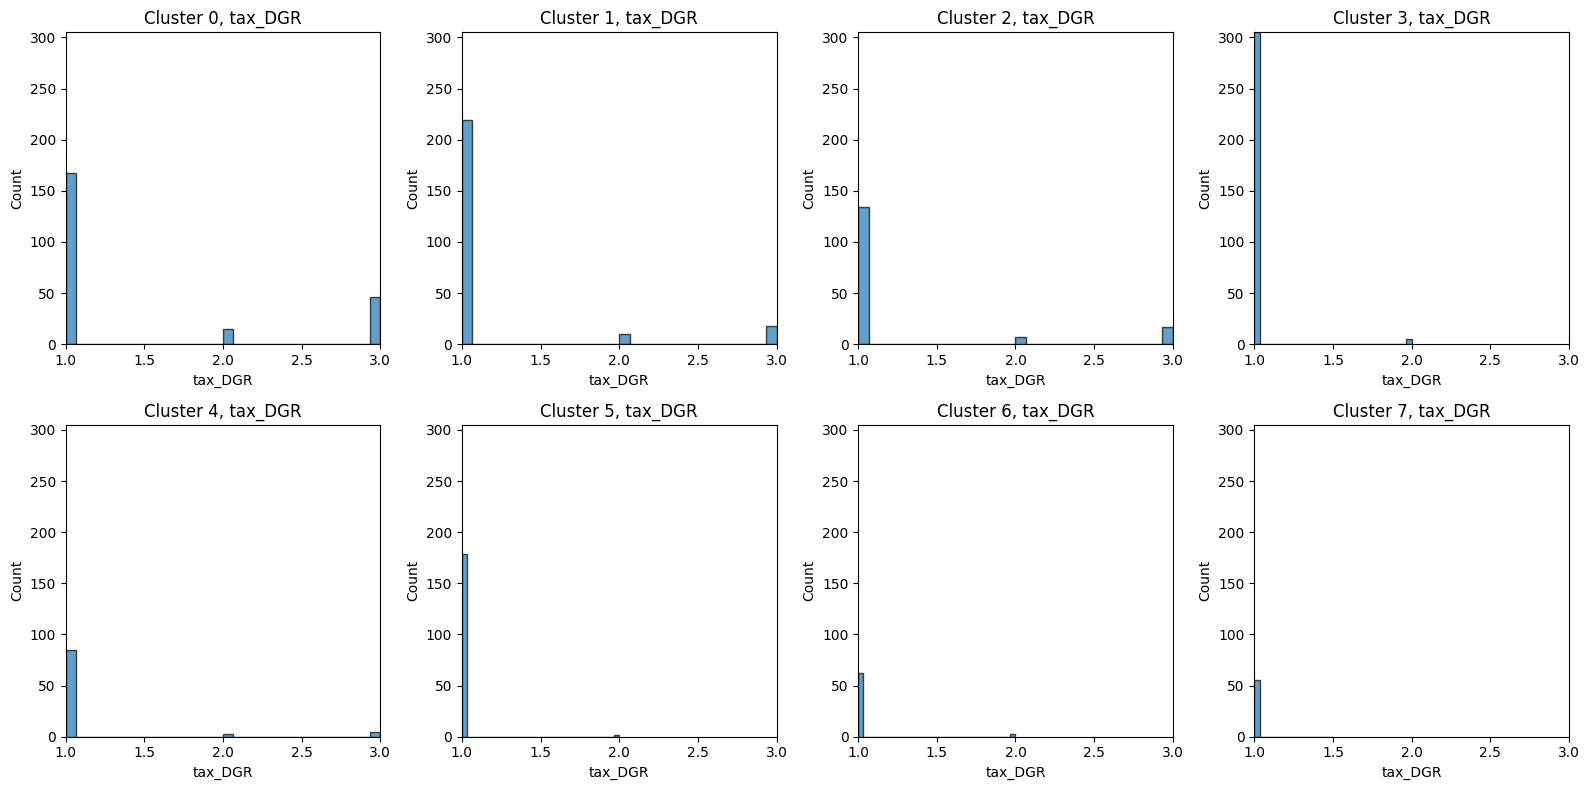

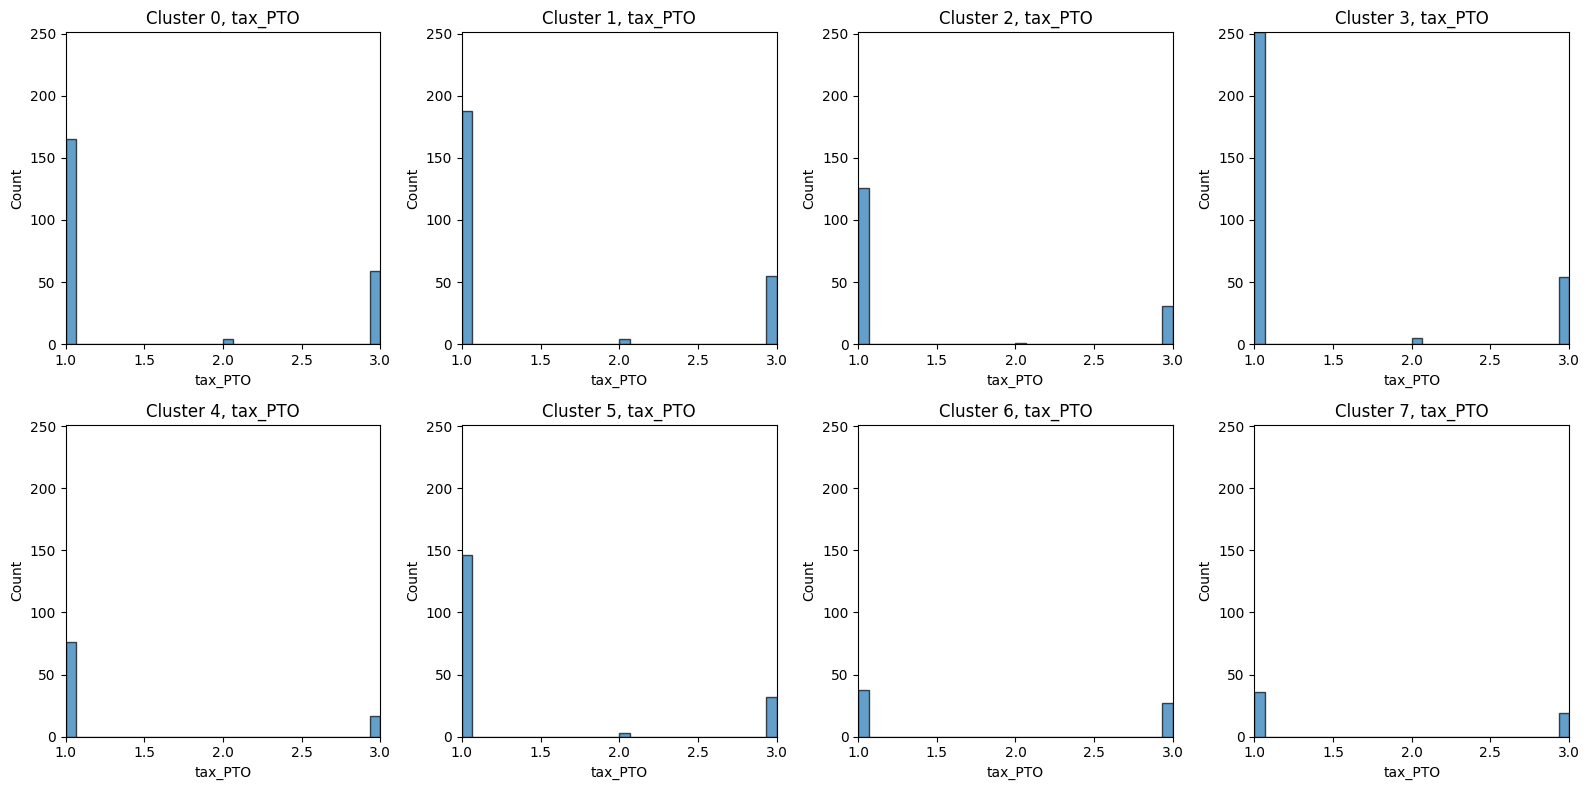

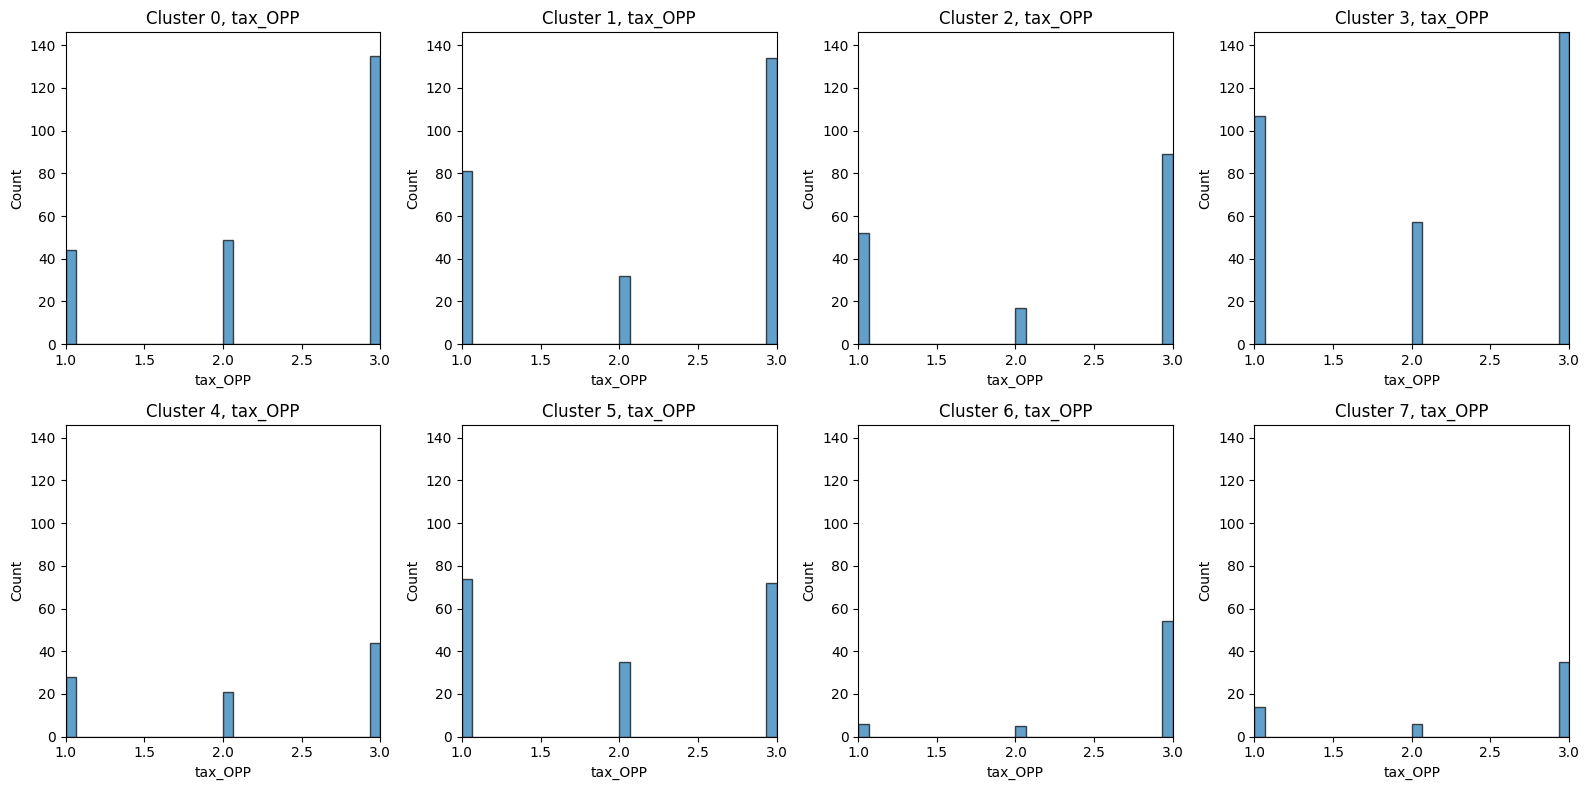

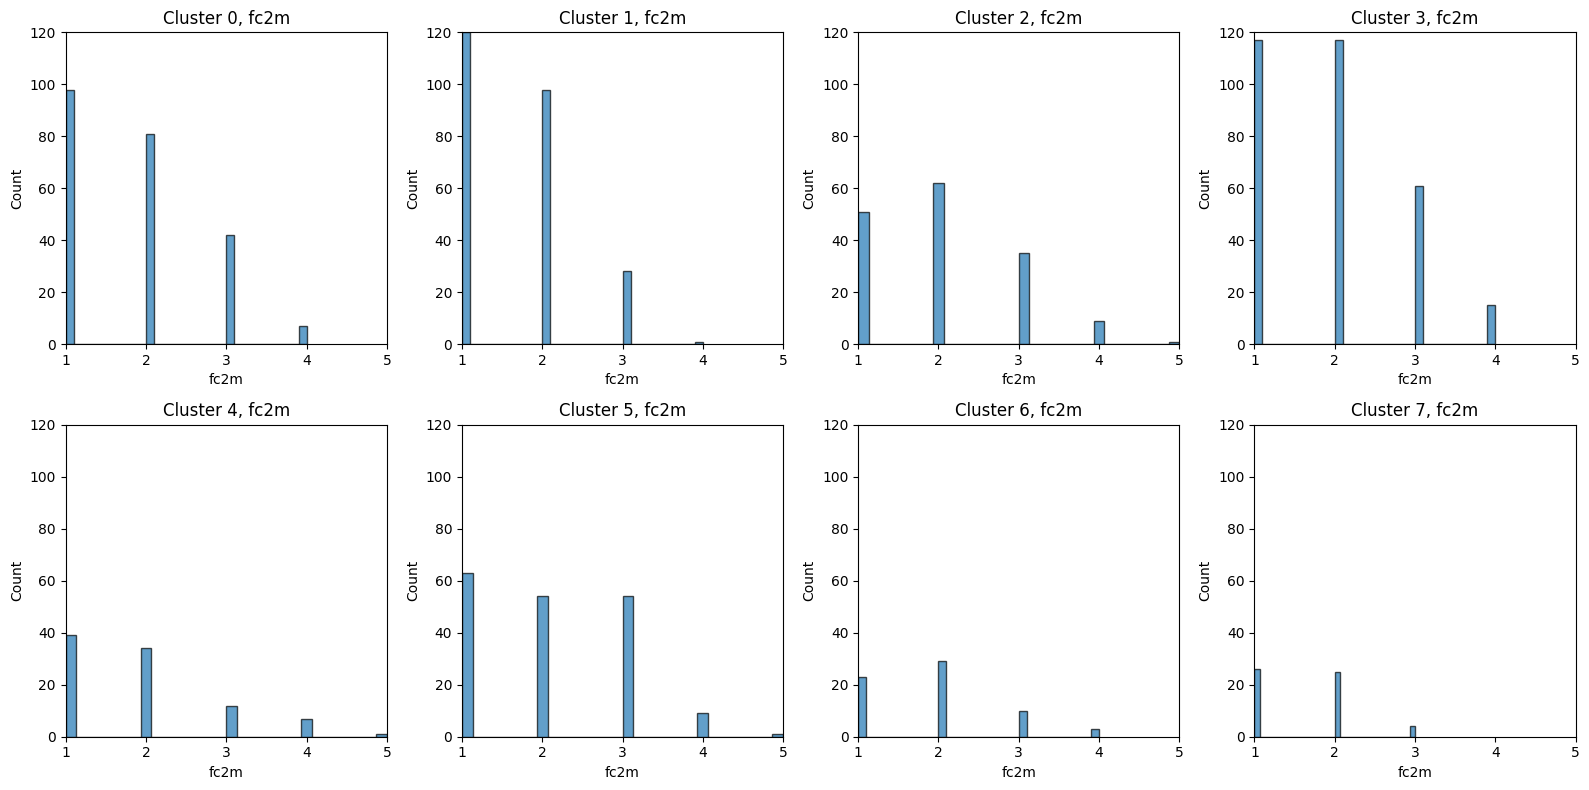

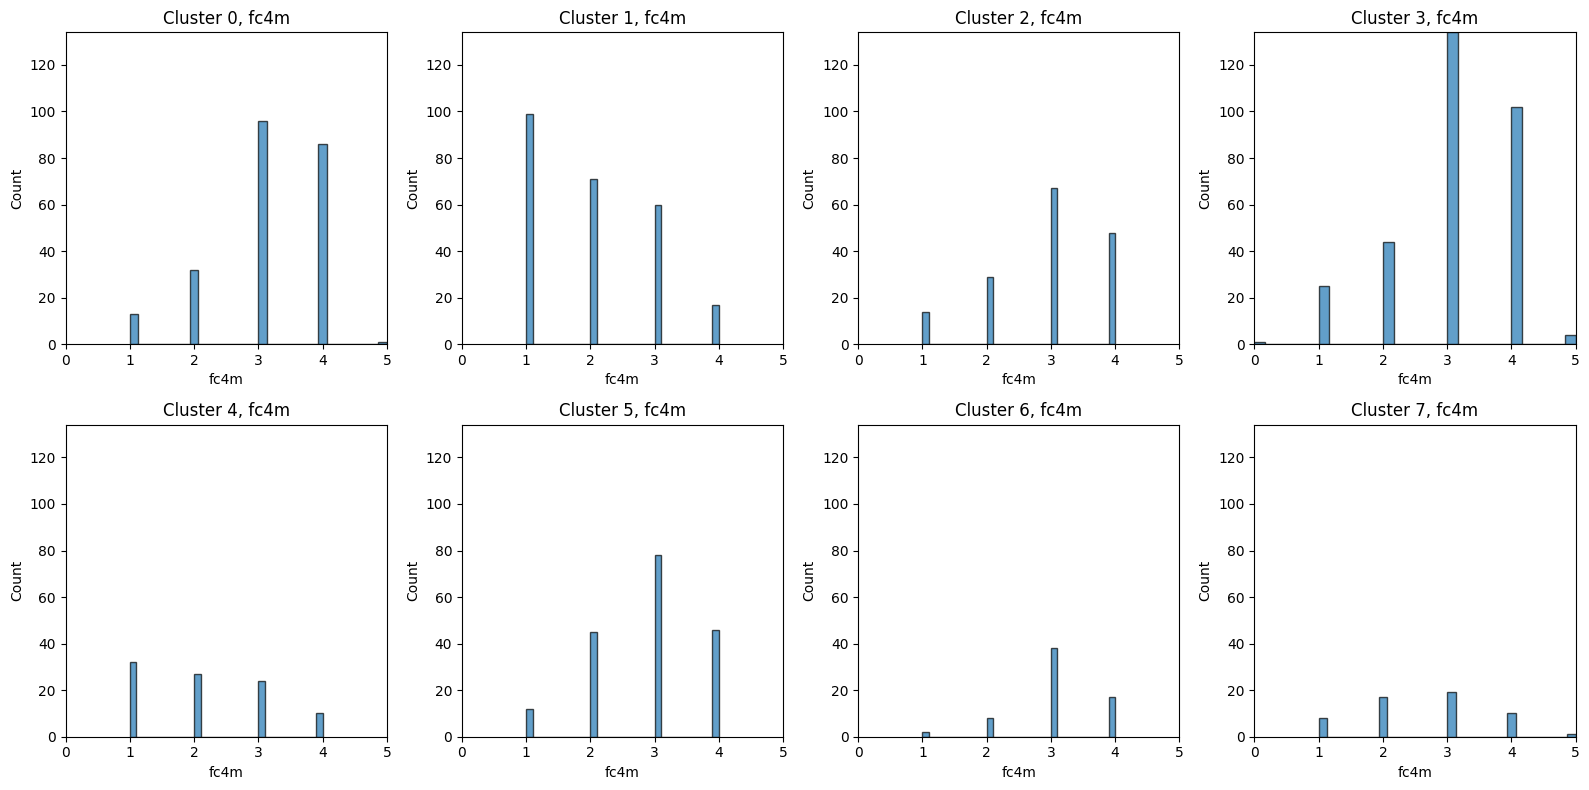

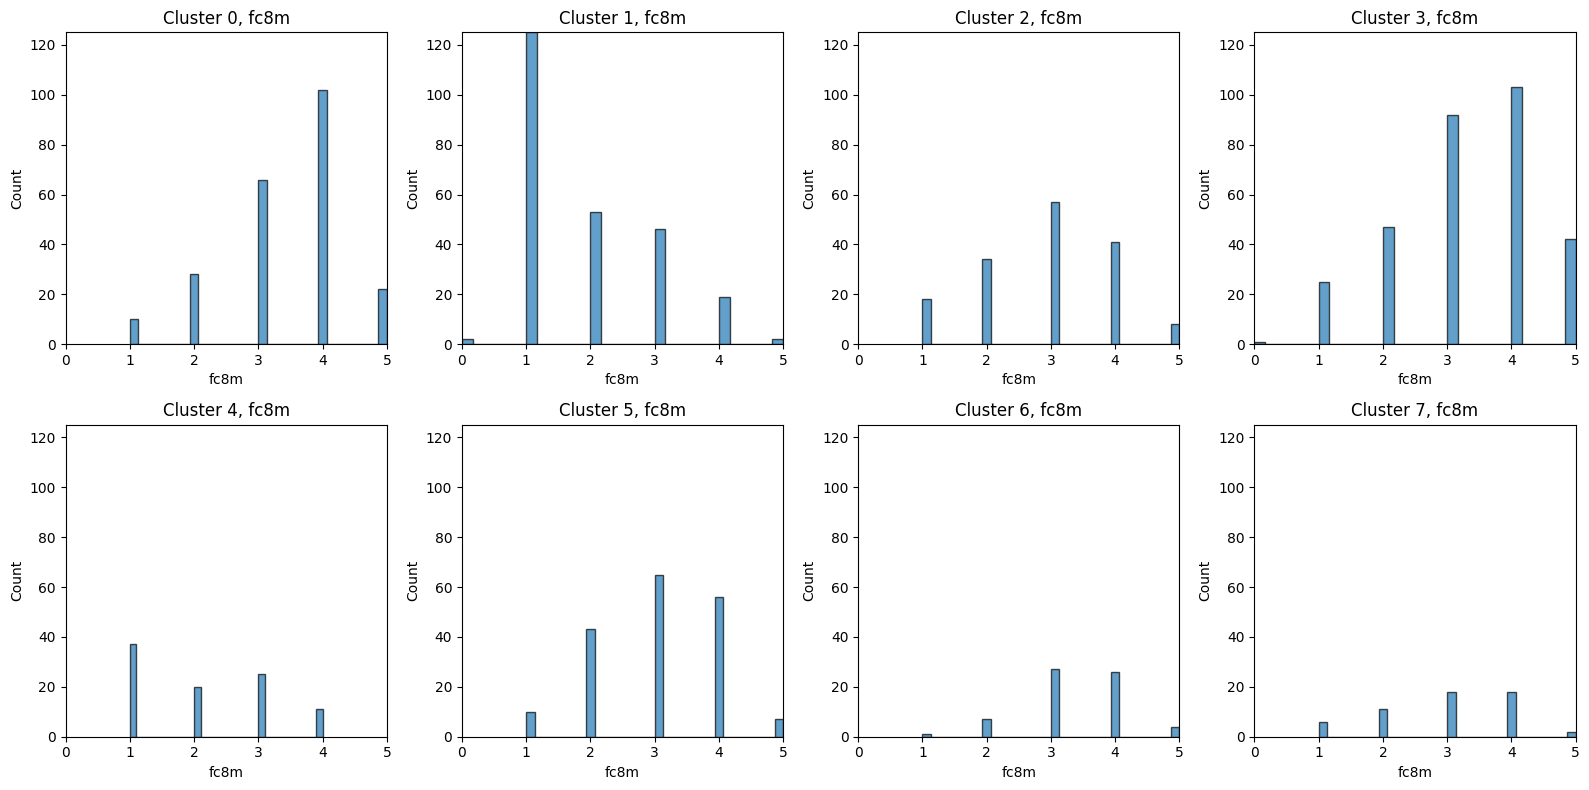

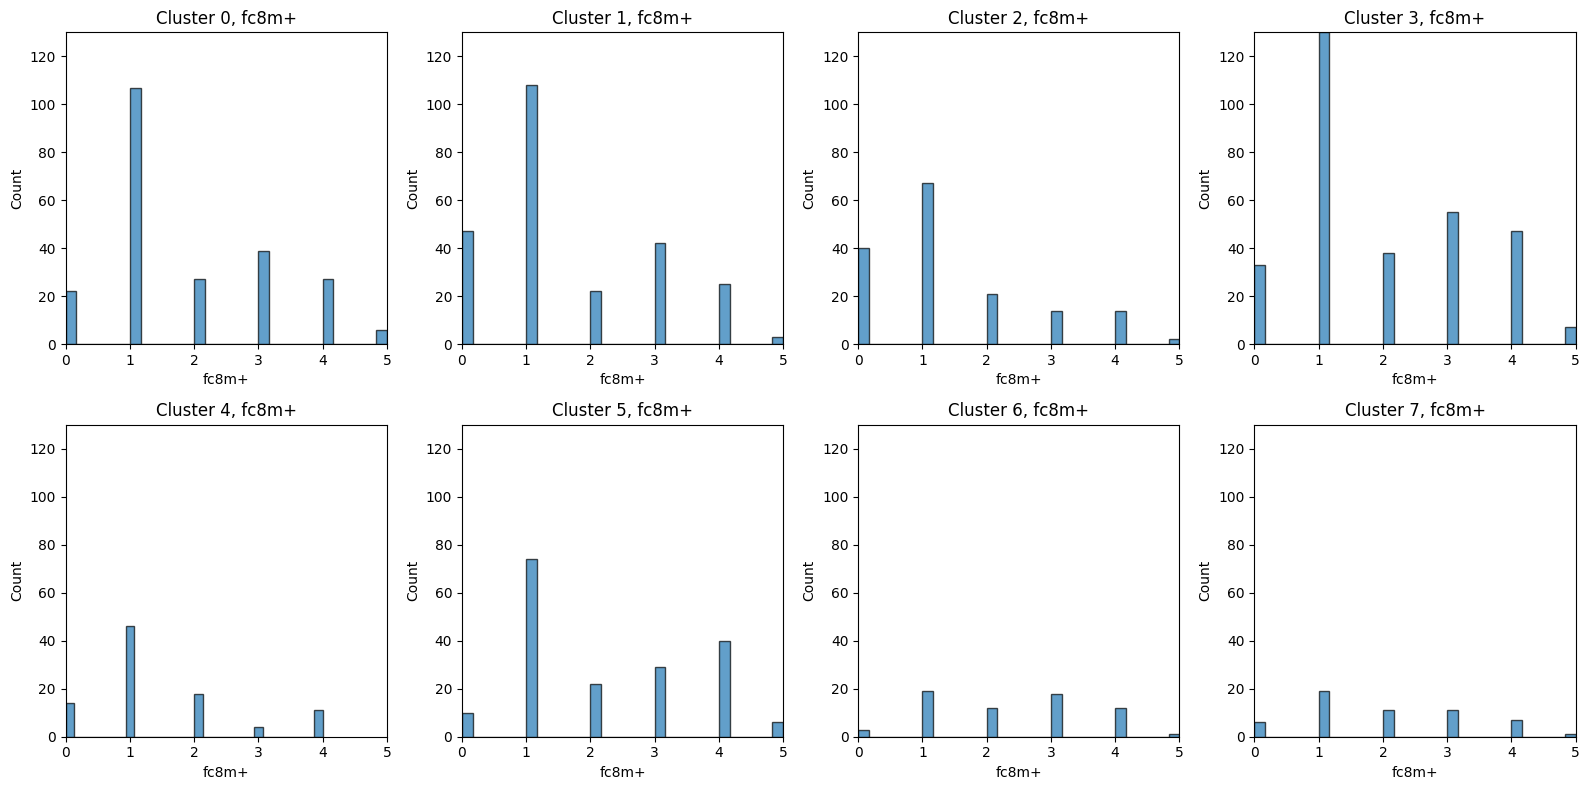

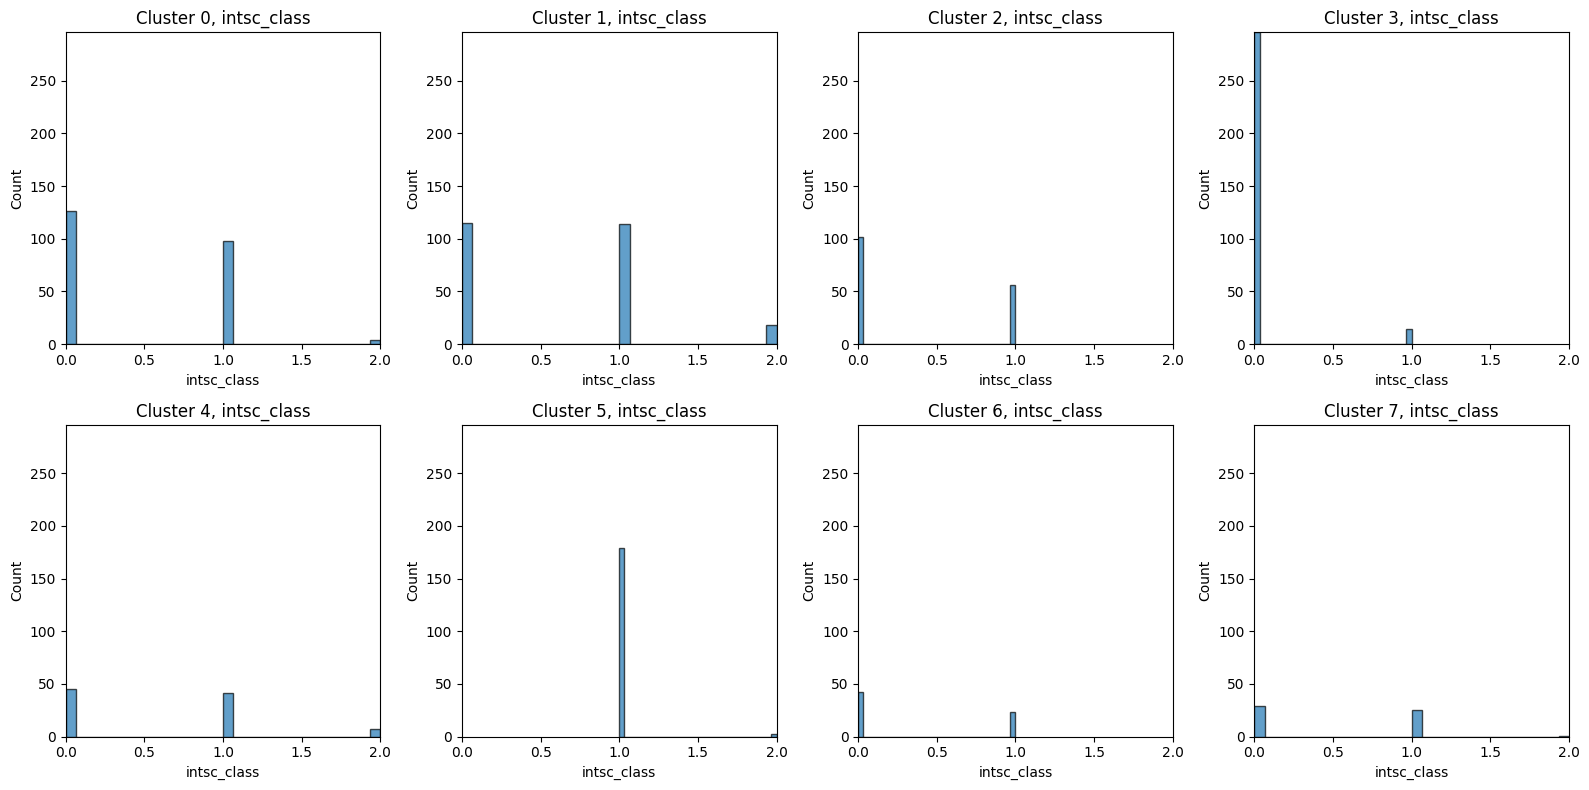

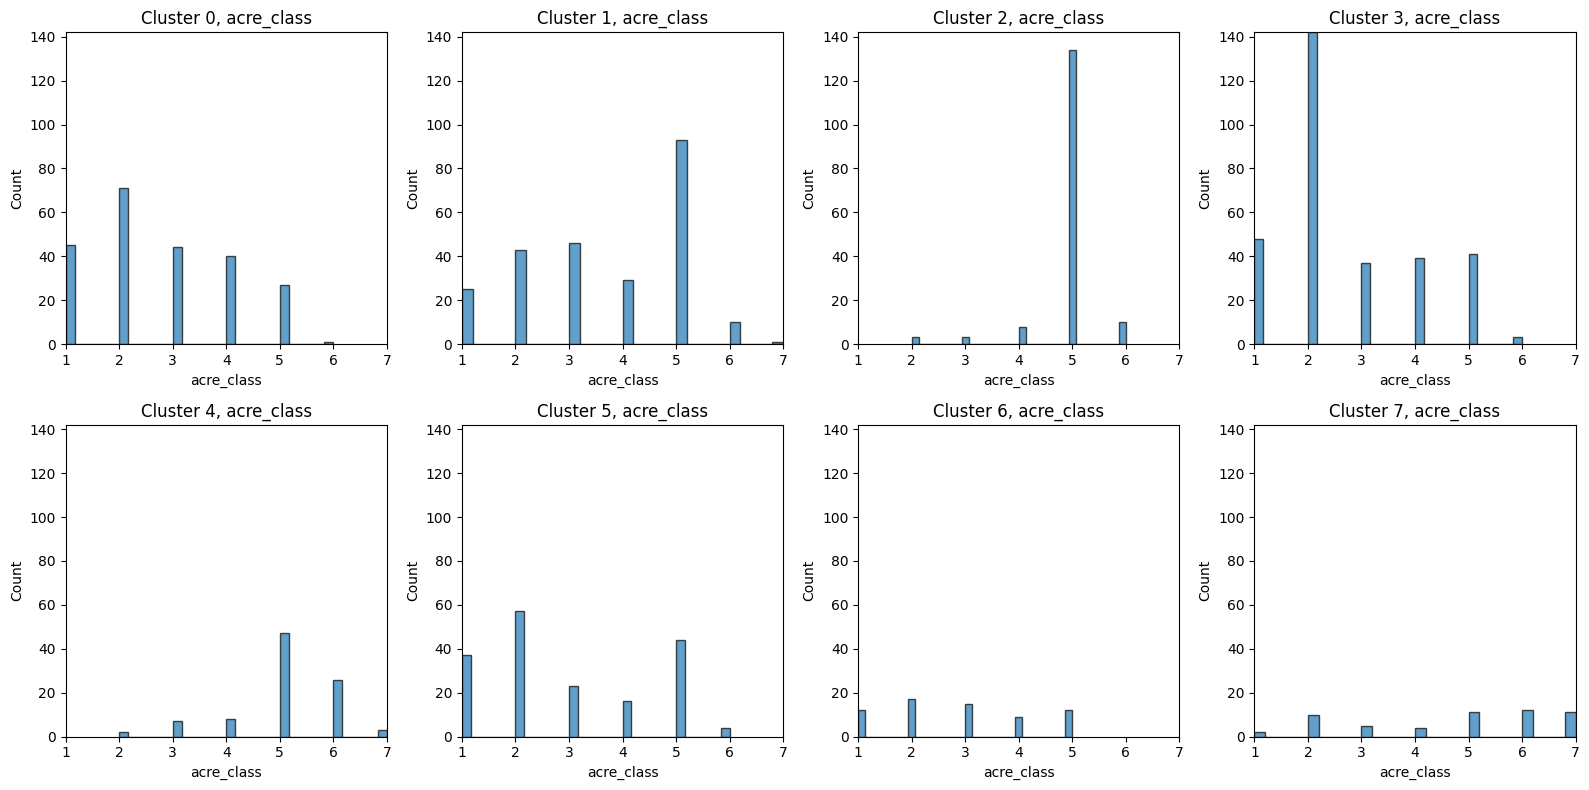

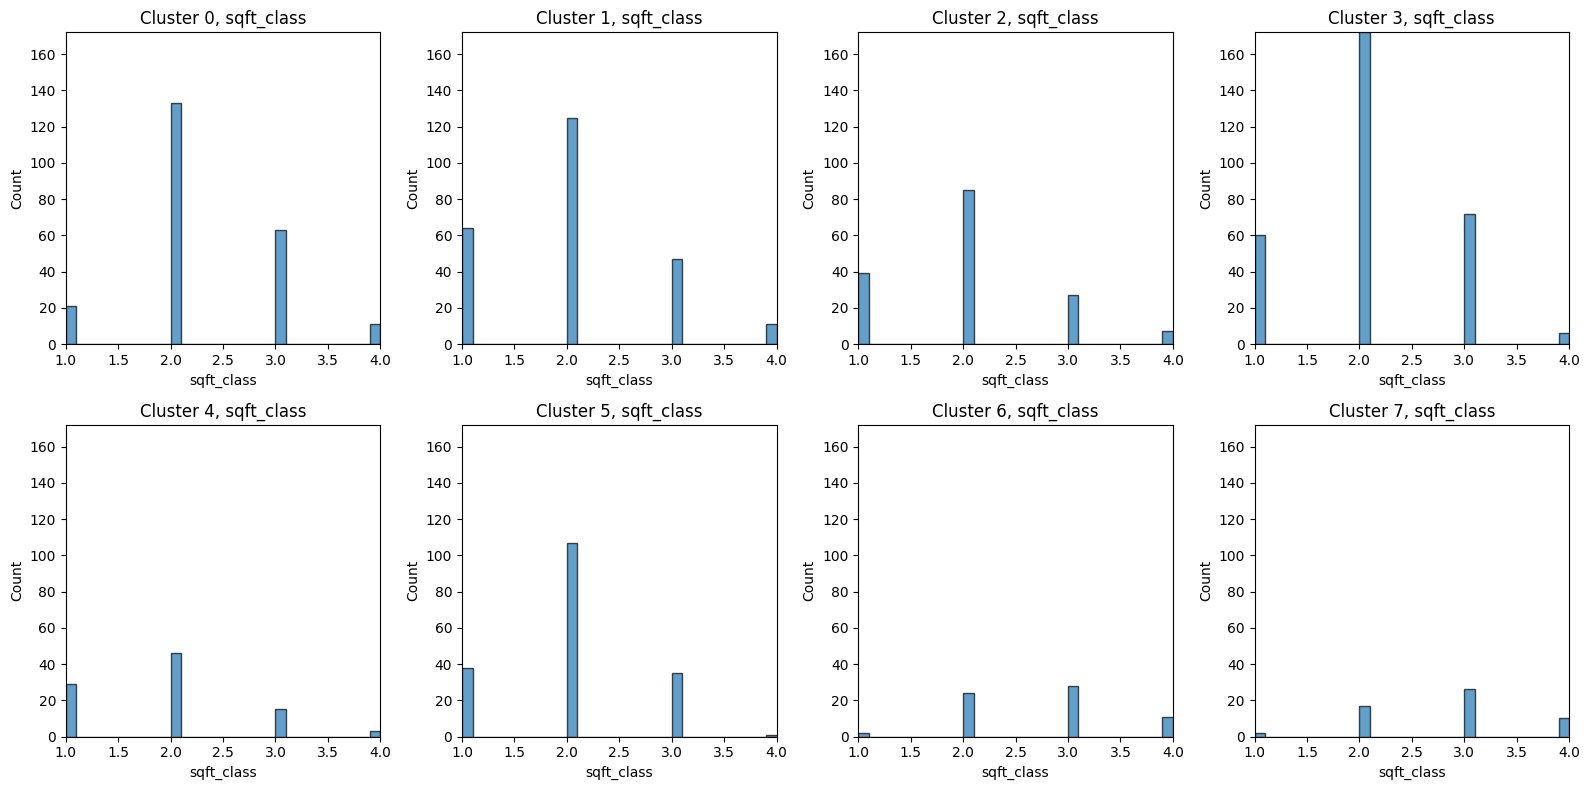

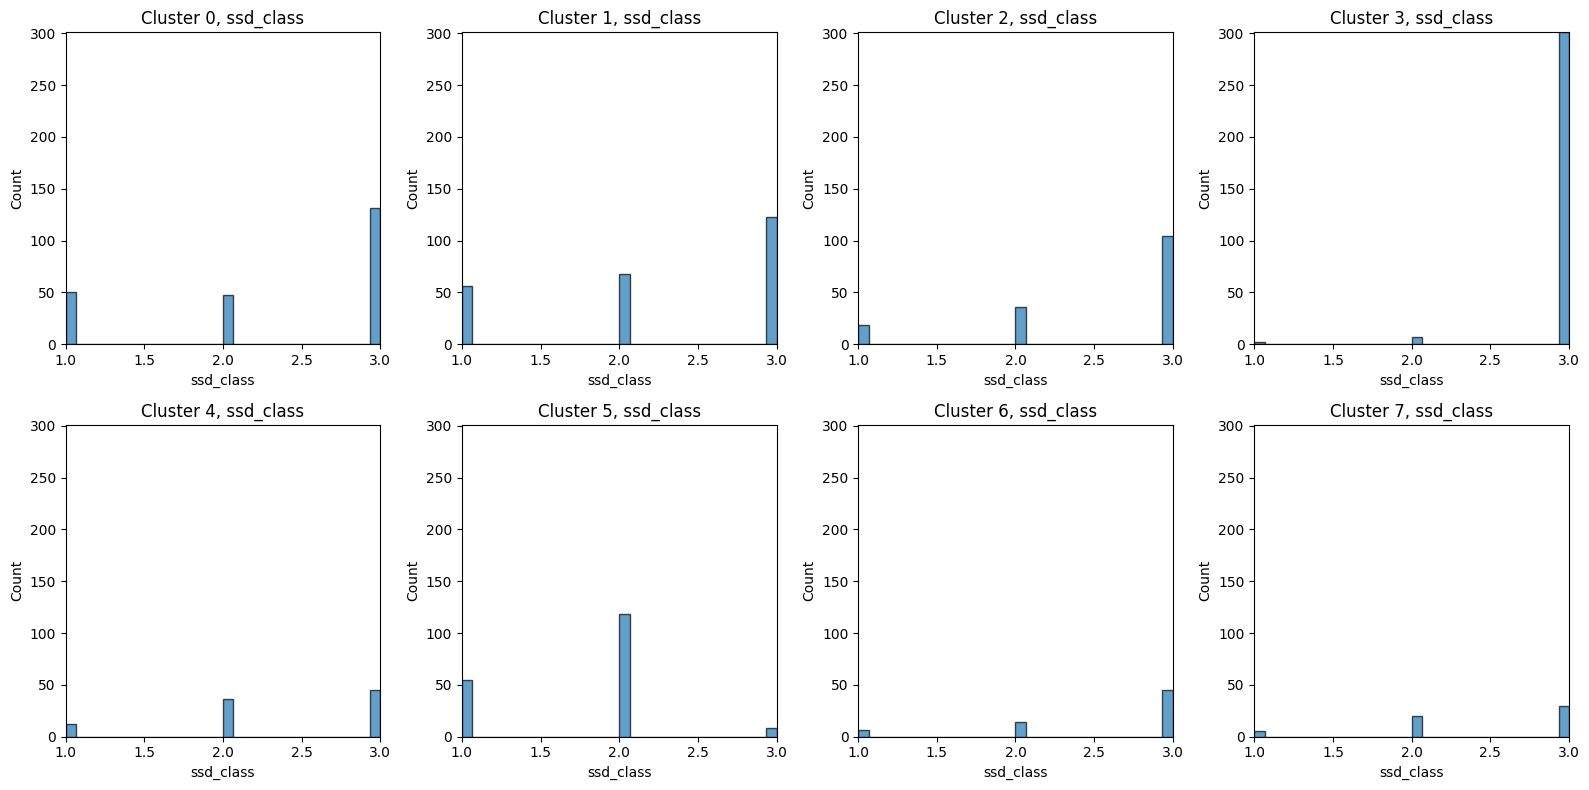

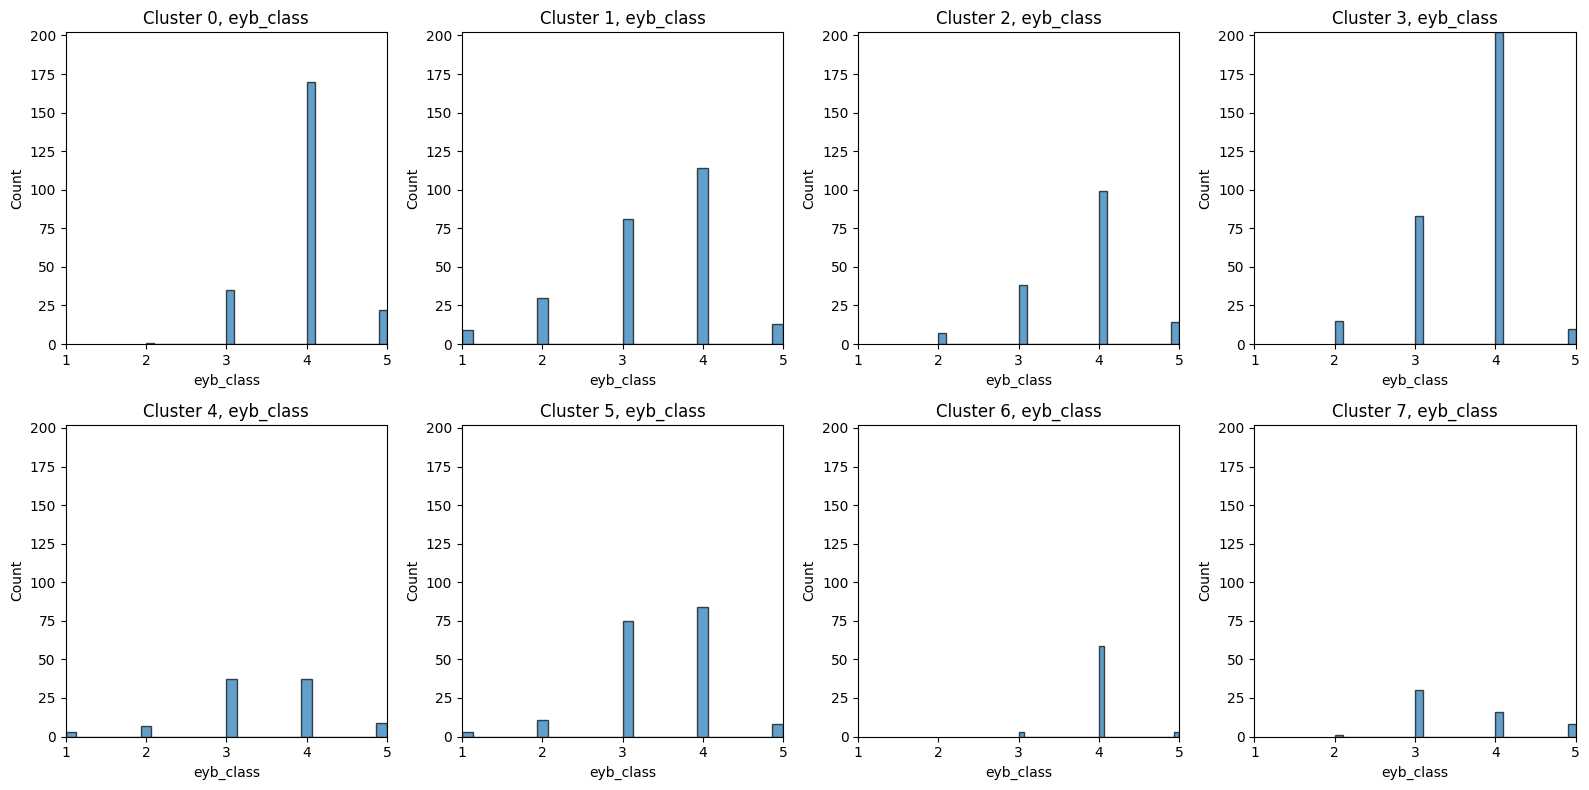

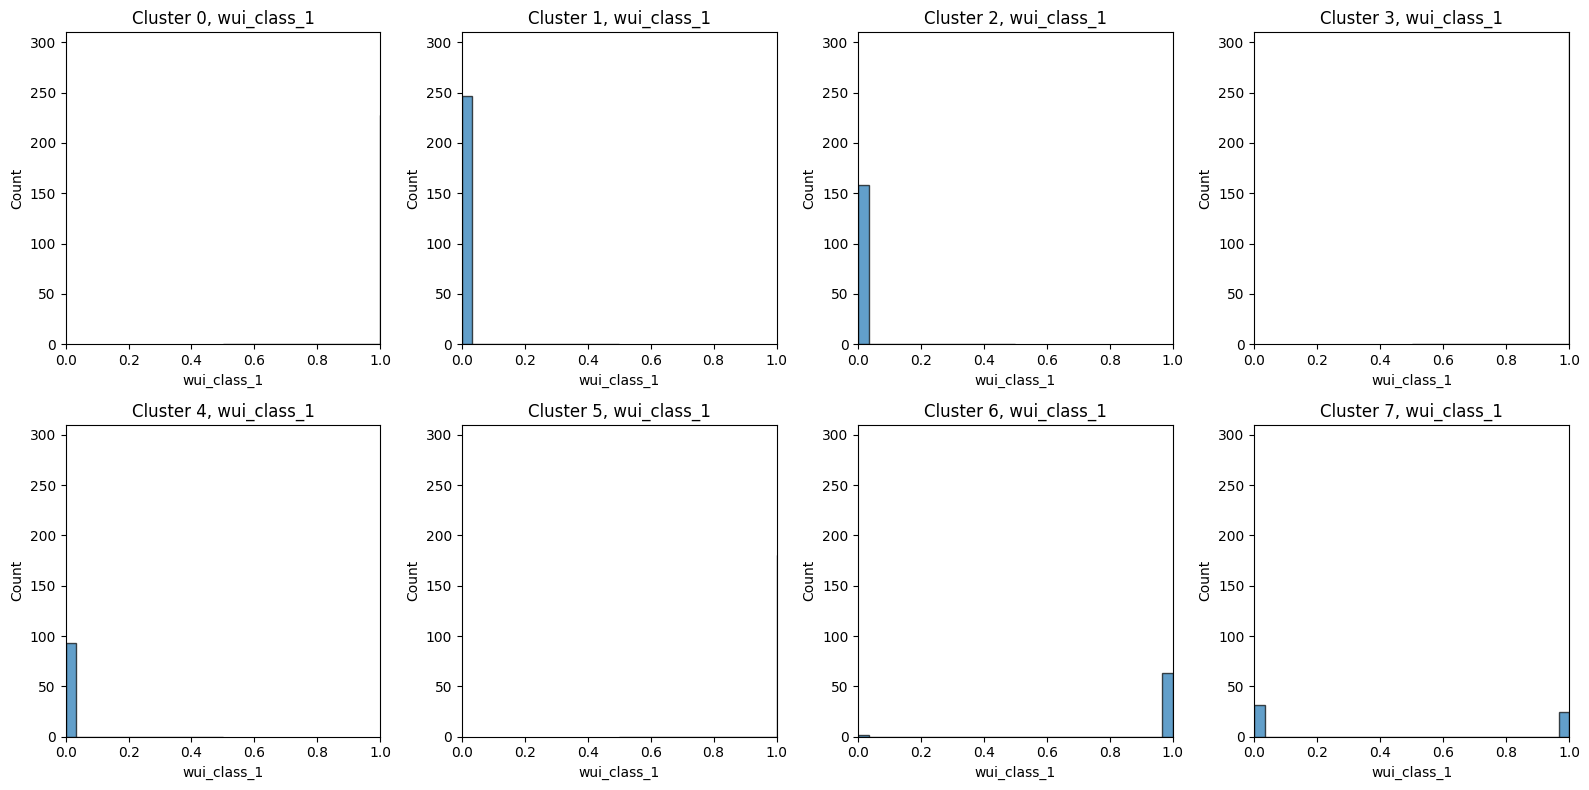

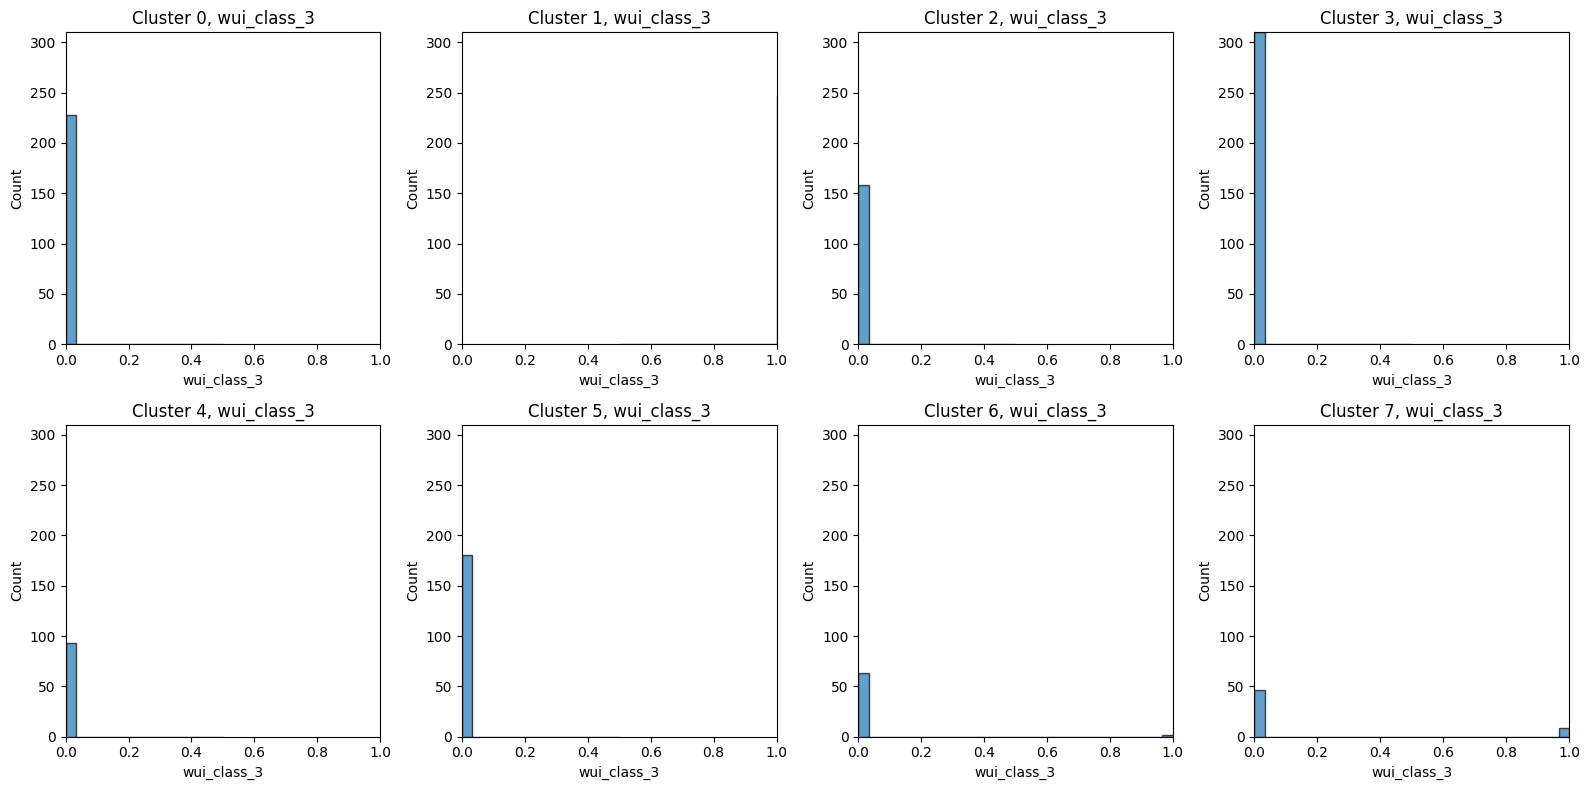

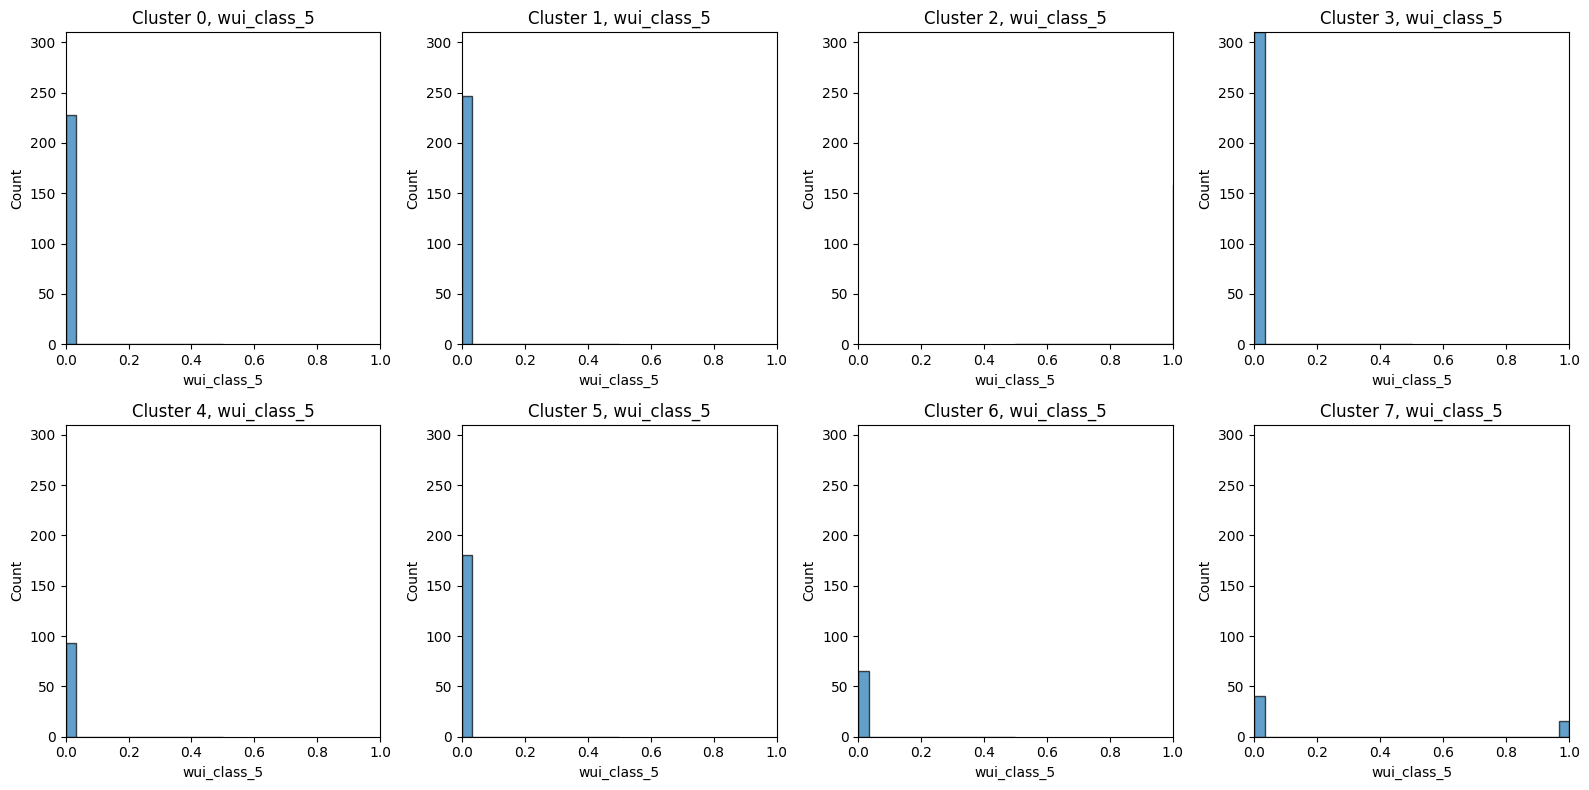

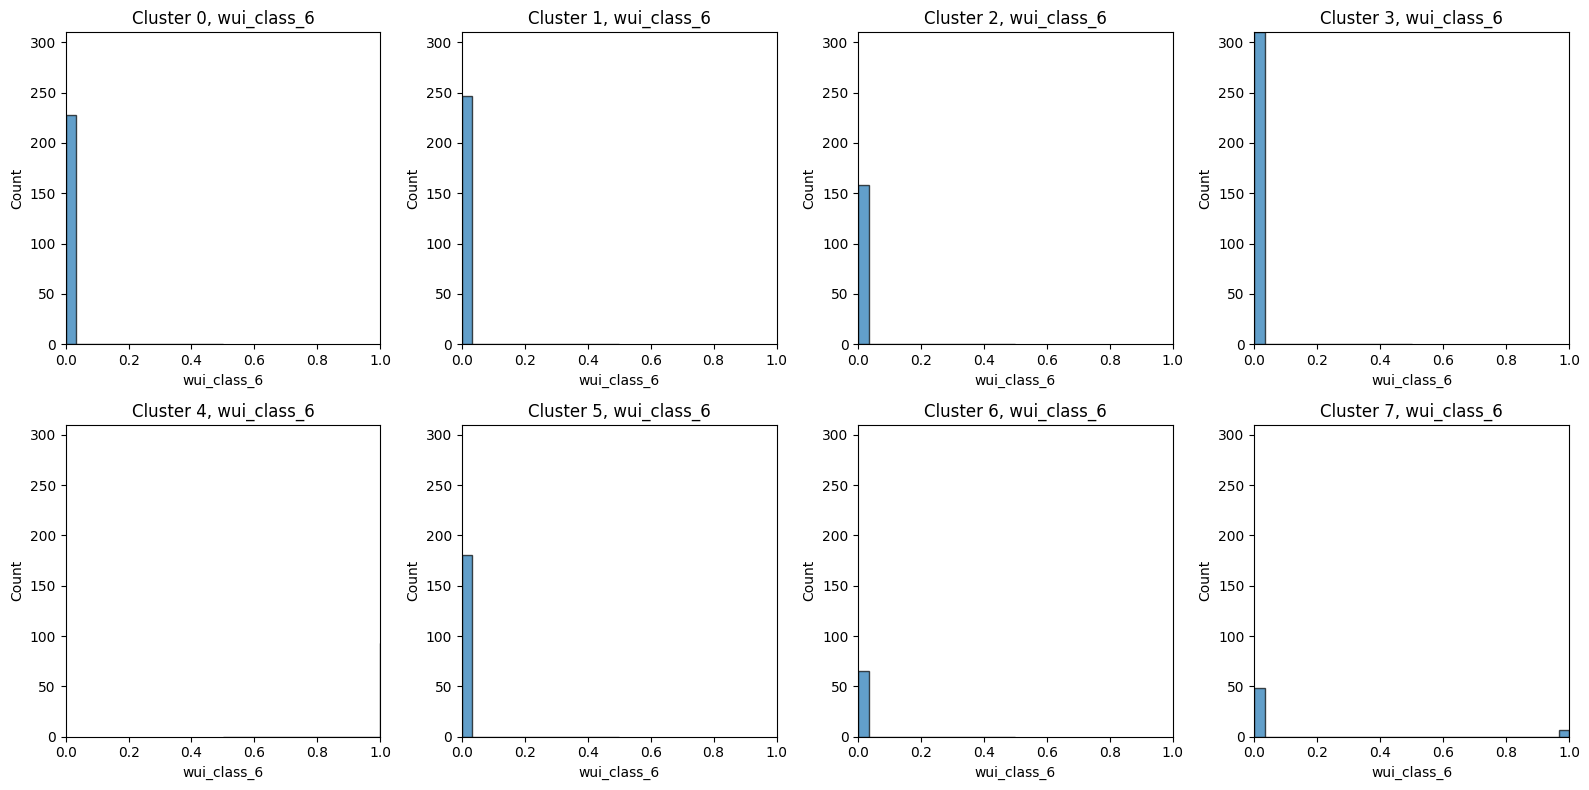

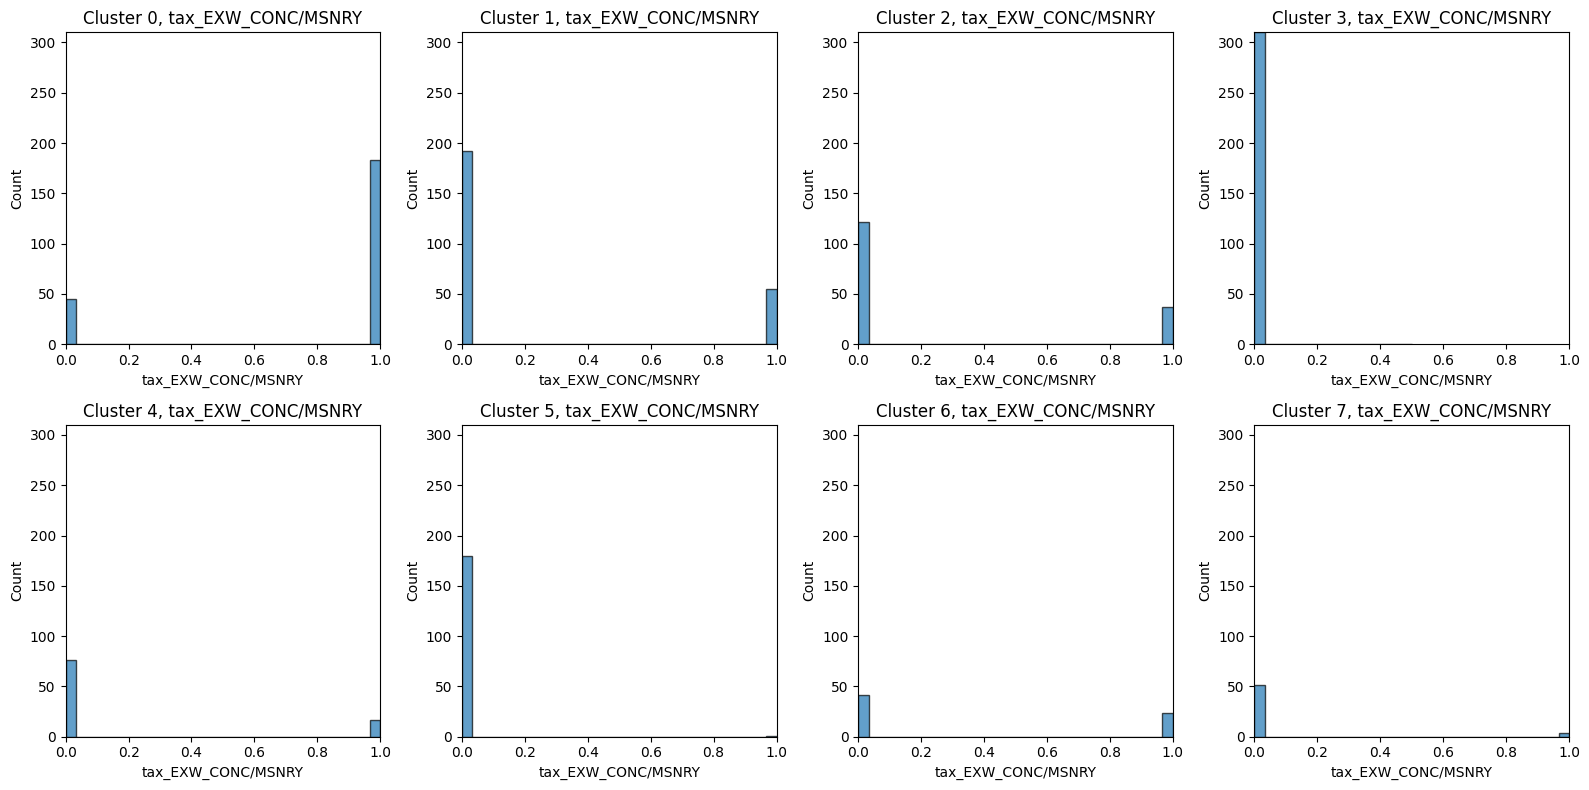

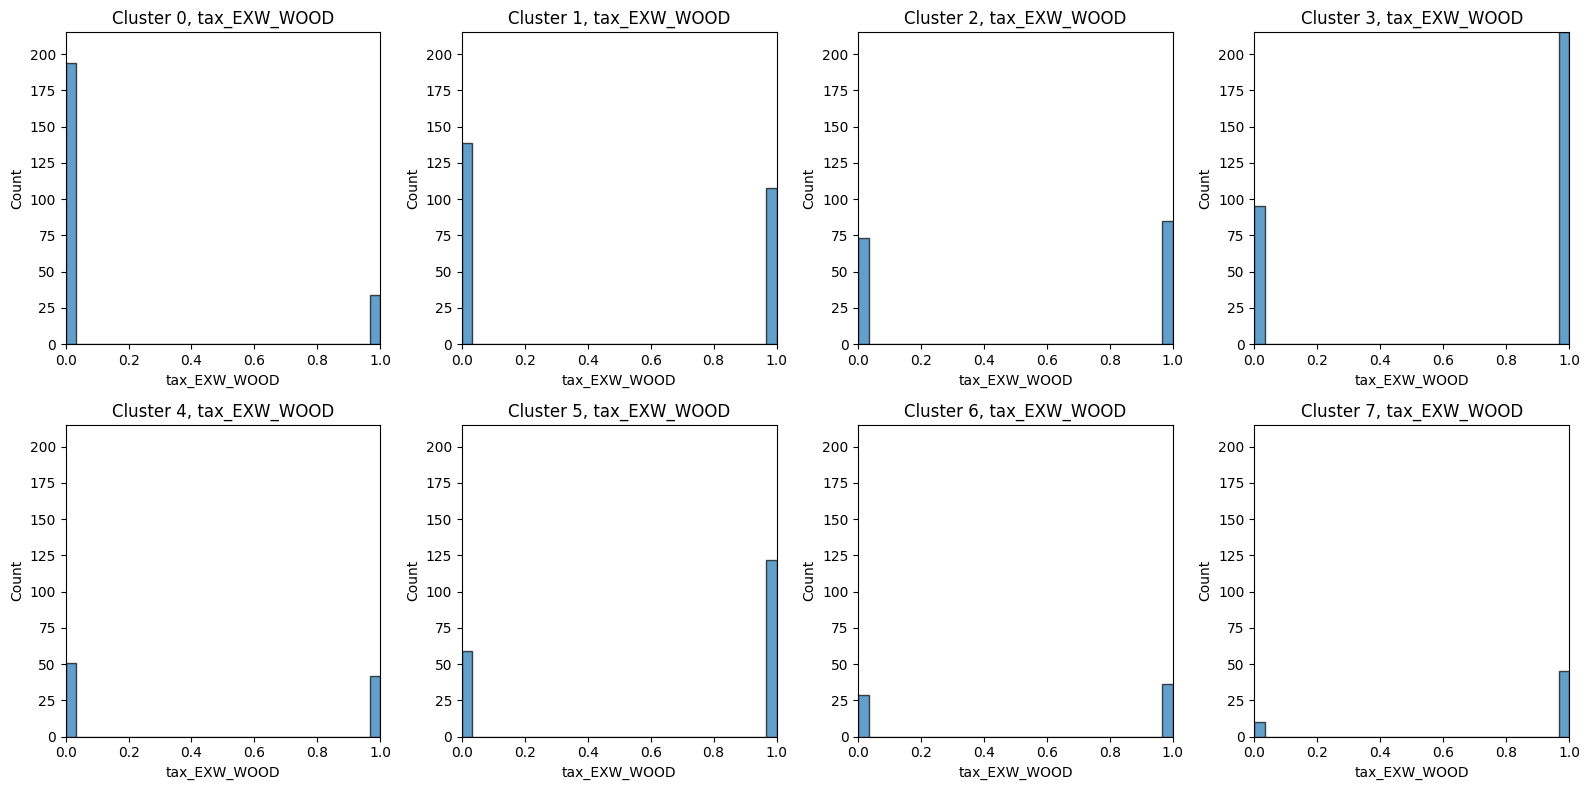

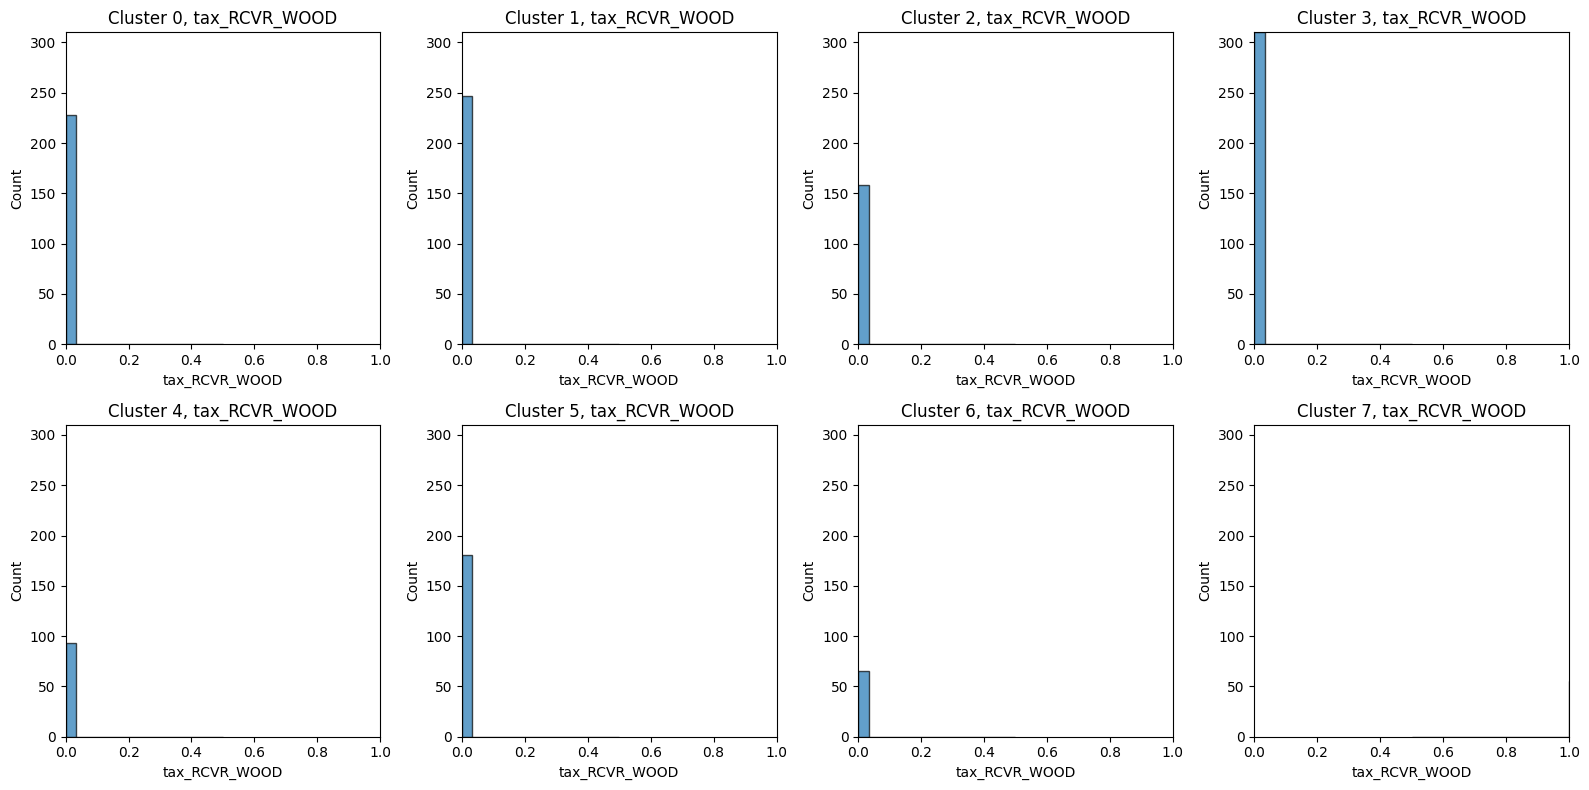

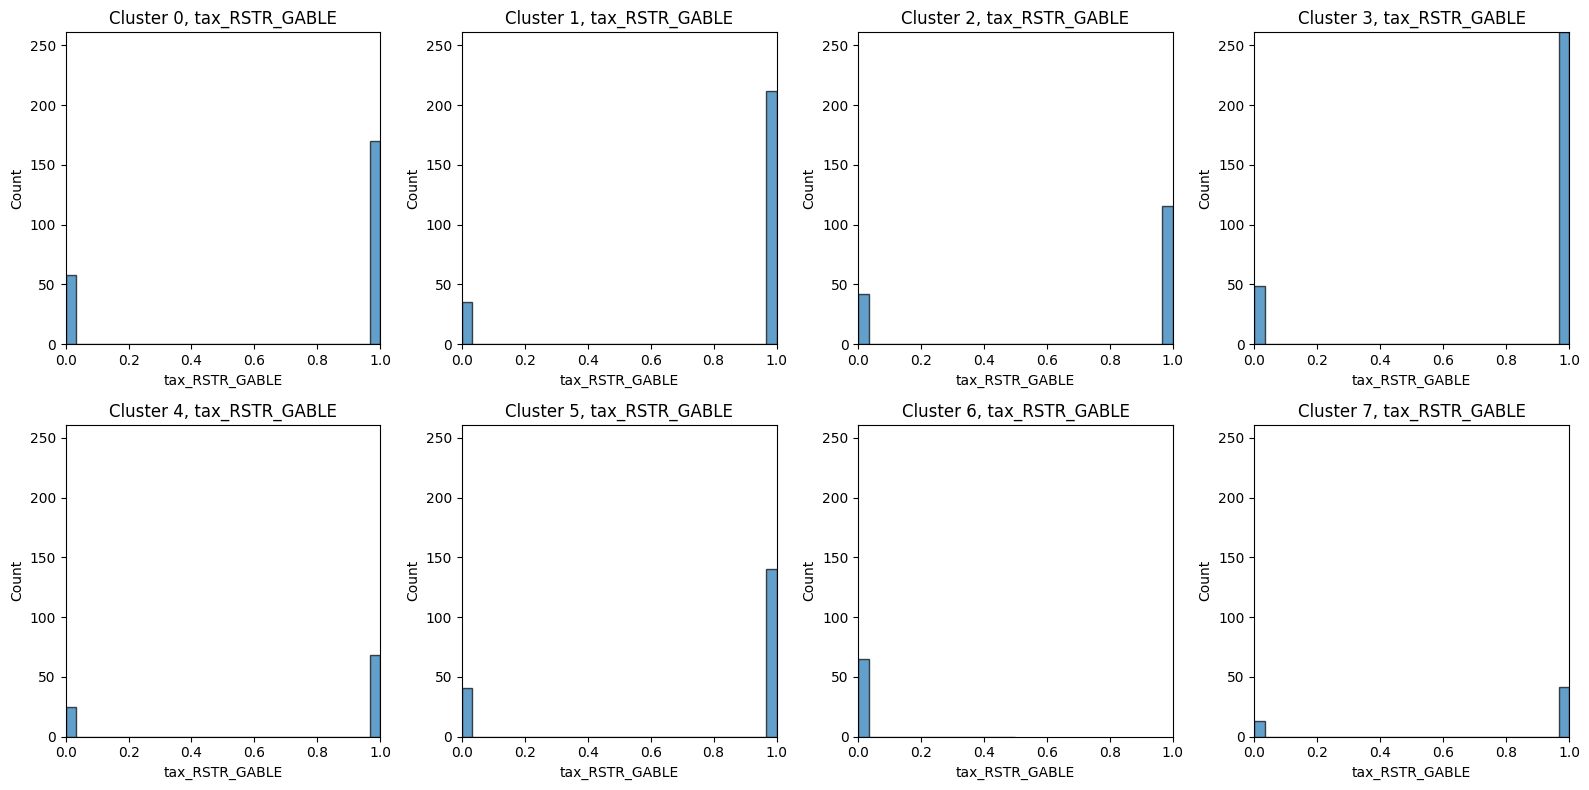

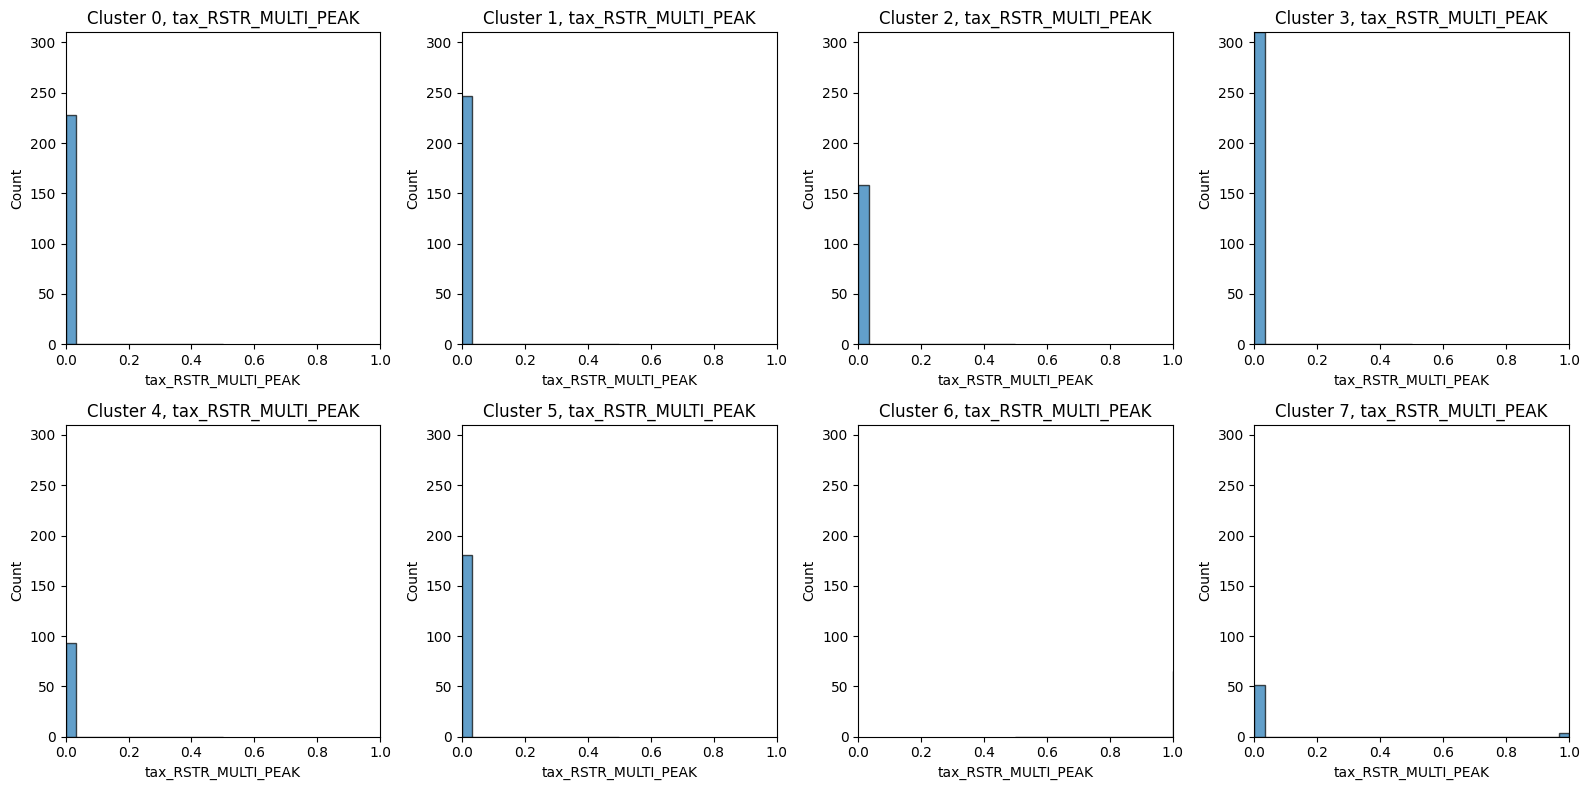

In [108]:
import matplotlib.pyplot as plt
import numpy as np

# Define function for plotting clusters in 2x4 subplots by feature
def plot_feature_histograms(feature, df):
    # Get unique clusters, excluding noise (-1)
    clusters = sorted(df['cluster_dbscan'].unique())
    clusters = [c for c in clusters if c != -1]  # Drop noise cluster

    fig, axes = plt.subplots(2, 4, figsize=(16, 8))  # 2x4 layout
    axes = axes.flatten()  # Convert to 1D array for easy indexing
    
    # 🏁 1️⃣ Find global x and y limits
    xmin, xmax = df[feature].min(), df[feature].max()  # X range across all clusters
    global_ymax = 0  # Track max count across all histograms

    # First pass: determine max count
    for cluster in clusters:
        cluster_data = df[df['cluster_dbscan'] == cluster][feature]
        counts, bins = np.histogram(cluster_data, bins=30)  # Get histogram counts
        global_ymax = max(global_ymax, counts.max())  # Track highest count
    
    # Second pass: plot with fixed limits
    for i, cluster in enumerate(clusters):
        cluster_data = df[df['cluster_dbscan'] == cluster]  # Filter by cluster
        axes[i].hist(cluster_data[feature], bins=30, alpha=0.7, edgecolor="black")

        # Set fixed axis limits
        axes[i].set_xlim(xmin, xmax)  
        axes[i].set_ylim(0, global_ymax)  

        axes[i].set_title(f"Cluster {cluster}, {feature}")
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel("Count")
    
    plt.tight_layout()
    plt.show()

# Plot all features for all clusters with fixed axis limits
for feature in tsne_cols:
    plot_feature_histograms(feature, df)


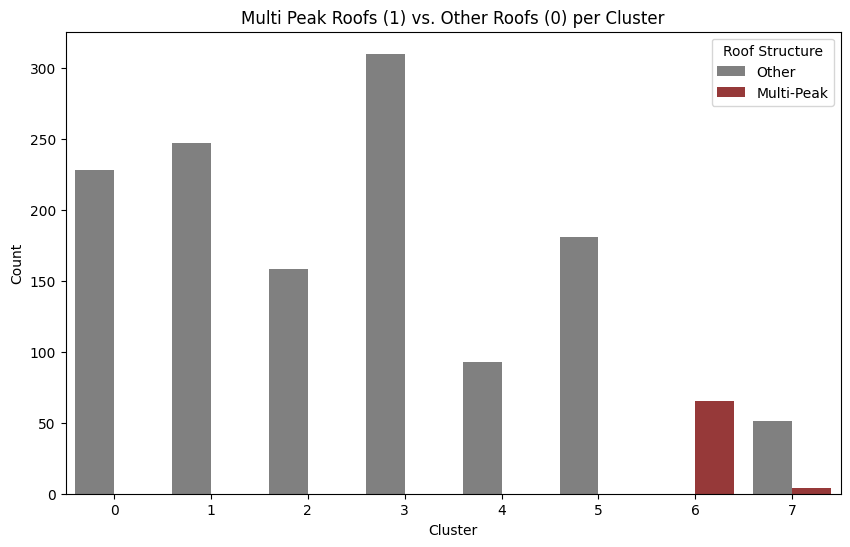

In [112]:
import seaborn as sns
import matplotlib.pyplot as plt

# Exclude noise cluster (-1)
df_filtered = df[df['cluster_dbscan'] != -1]

# Plot counts of wood vs. non-wood roofs per cluster
plt.figure(figsize=(10, 6))
sns.countplot(data=df_filtered, x="cluster_dbscan", hue="tax_RSTR_MULTI_PEAK", palette=["gray", "brown"])

plt.xlabel("Cluster")
plt.ylabel("Count")
plt.title("Multi Peak Roofs (1) vs. Other Roofs (0) per Cluster")
plt.legend(title="Roof Structure", labels=["Other", "Multi-Peak"])
plt.show()

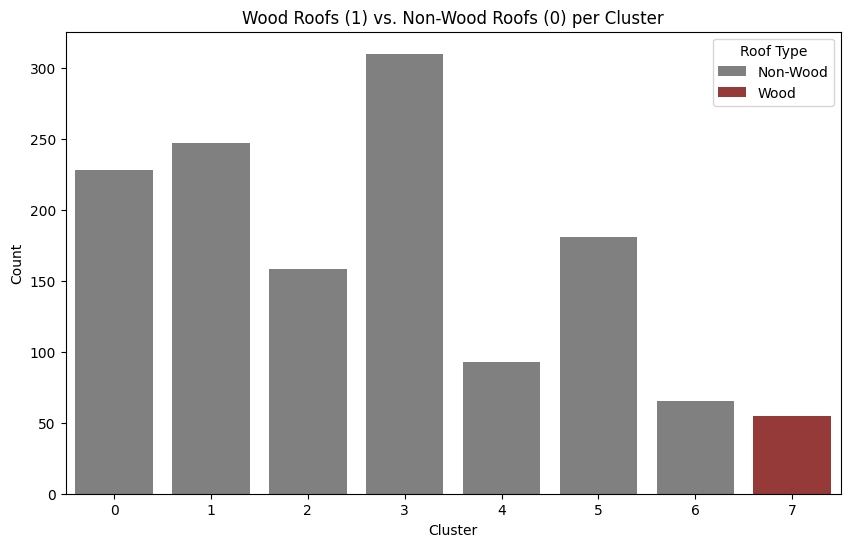

In [109]:
import seaborn as sns
import matplotlib.pyplot as plt

# Exclude noise cluster (-1)
df_filtered = df[df['cluster_dbscan'] != -1]

# Plot counts of wood vs. non-wood roofs per cluster
plt.figure(figsize=(10, 6))
sns.countplot(data=df_filtered, x="cluster_dbscan", hue="tax_RCVR_WOOD", palette=["gray", "brown"])

plt.xlabel("Cluster")
plt.ylabel("Count")
plt.title("Wood Roofs (1) vs. Non-Wood Roofs (0) per Cluster")
plt.legend(title="Roof Type", labels=["Non-Wood", "Wood"])
plt.show()


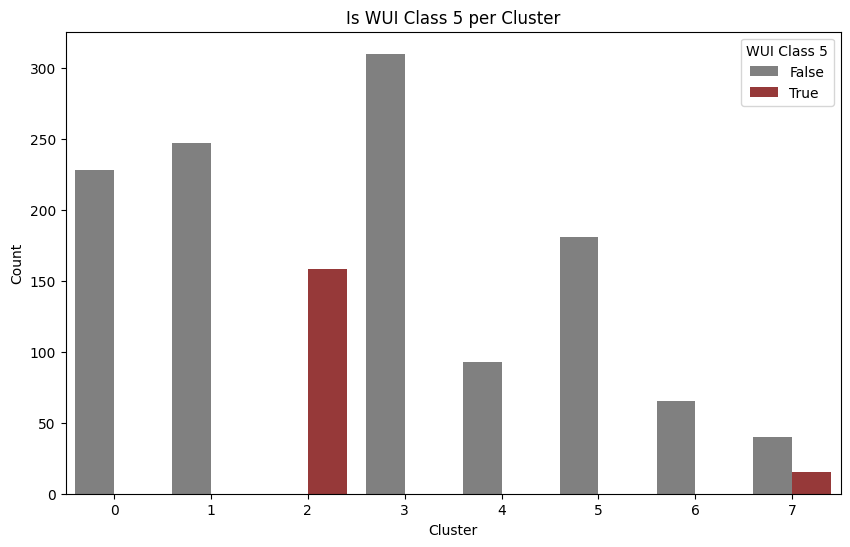

In [115]:
import seaborn as sns
import matplotlib.pyplot as plt

# Exclude noise cluster (-1)
df_filtered = df[df['cluster_dbscan'] != -1]

# Plot counts of wood vs. non-wood roofs per cluster
plt.figure(figsize=(10, 6))
sns.countplot(data=df_filtered, x="cluster_dbscan", hue="wui_class_5", palette=["gray", "brown"])

plt.xlabel("Cluster")
plt.ylabel("Count")
plt.title("Is WUI Class 5 per Cluster")
plt.legend(title="WUI Class 5", labels=["False", "True"])
plt.show()

## Joining Clusters to GPKG
---
Here we join the clusters to a geopackage and save as a new geopackage. This is called `clusters.gpkg`. We export this to a new file for spatial analysis and for creating figures in ArcGIS Pro.

In [118]:
import geopandas as gpd

gdf = gpd.read_file(os.path.join(out, 'feat_risk_refact.gpkg'), layer='risk_reclass')
gdf.shape
gdf.head()

,rwra_index,feat_index,parcel_num,Year,address,ParcelNum,Model,Address_Visible,Driveway_Clearance,Driveway_Lenth,Dist_to_Danger_Topo,Slope_Final,Background_Fuels,Defensible_Space,Roofing_Material,Building_Exterior,Other_Combustibles,Decks_and_Fencing,Proximity_to_Neighboring_Home,Ingress_Egress,Score_Final,Risk_Rating,County,wui_class,min_ssd,mean_cc0_2m,mean_cc2_4m,mean_cc4_8m,mean_cc8_40m,intersections,PARCELNB,ACCOUNT,ACRES_calc,hiz_ext_out,Air Conditioning\n(AIRC),tax_ARCH,tax_SQFT,tax_COND,tax_EYB,Exterior Percent\n(EXW_PERCENT),tax_EXW,Floor\n(FLR),Frame\n(FRME),tax_HTFL,Interior Wall\n(INT),tax_RMS,tax_RCVR,tax_RSTR,Type,sum_cc,tax_WBL,tax_DGR,tax_PTO,tax_OPP,Risk_Rating_new,geometry
0,0,2836,430506210001,2013.0,123 EXAMPLE DRIVE,430506210001,A,0,5,NaN,0,NaN,75,75,0,0,10,50,NaN,10,225.0,High,Ouray County,1,31.525324,0.028983,0.080487,0.112609,0.179108,1,430506210001,R003918,49.6527,True,1 - NONE,COMMERCIAL,6991.1,3 - GOOD,2015.0,10.0,CONC/MSNRY,CONC/MSNRY,WOOD,PROPANE,DRYWALL,0.776148,METAL,GABLE,Commercial,0.401187,None,None,None,Large,Moderate,POINT (255148.616 4230223.23)
1,1,1110,430506210001,2013.0,129 EXAMPLE DRIVE,430506210001,A,0,5,NaN,0,NaN,50,50,0,20,10,0,NaN,0,135.0,Low,Ouray County,1,31.525324,0.051442,0.096132,0.093393,0.155315,1,430506210001,R003918,49.6527,False,1 - NONE,COMMERCIAL,6991.1,3 - GOOD,2015.0,10.0,CONC/MSNRY,CONC/MSNRY,WOOD,PROPANE,DRYWALL,0.776148,METAL,GABLE,Commercial,0.396283,None,None,None,Large,Low,POINT (255108.006 4230179.848)
2,2,3672,430506210001,2013.0,135 EXAMPLE DRIVE,430506210001,A,0,5,NaN,75,NaN,50,100,0,60,10,50,NaN,10,360.0,Extreme,Ouray County,1,66.164004,0.035089,0.059277,0.031211,0.026098,0,430506210001,R003918,49.6527,True,1 - NONE,COMMERCIAL,6991.1,3 - GOOD,2015.0,10.0,CONC/MSNRY,CONC/MSNRY,WOOD,PROPANE,DRYWALL,0.776148,METAL,GABLE,Commercial,0.151675,None,None,None,Large,Moderate,POINT (255042.316 4230227.366)
3,3,3843,430506210001,2013.0,141 EXAMPLE DRIVE,430506210001,A,0,0,NaN,0,NaN,50,75,200,60,30,0,NaN,0,415.0,Extreme,Ouray County,1,78.033957,0.054498,0.065344,0.076959,0.213781,0,430506210001,R003918,49.6527,False,1 - NONE,COMMERCIAL,6991.1,3 - GOOD,2015.0,10.0,CONC/MSNRY,CONC/MSNRY,WOOD,PROPANE,DRYWALL,0.776148,METAL,GABLE,Commercial,0.410582,None,None,None,Large,High,POINT (255079.817 4230091.78)
4,5,921,403935100181,2017.0,416 COUNTY ROAD 22A,403935100181,B,5,0,11.0,0,0.0,10,50,0,0,0,0,0.0,0,76.0,Low,Ouray County,1,211.505051,0.048738,0.084885,0.034318,0.000000,0,403935100181,R000531,32.7283,False,1 - NONE,SINGLE STORY,4034.9,3 - GOOD,2015.0,100.0,CONC/MSNRY,WDJST,WOOD,GAS,DRYWALL,0.776148,ASPHALT,GABLE,Residence,0.167940,None,None,Large,Large,Low,POINT (252995.437 4241729.295)


In [119]:
print(tsne_cols)

['tax_WBL', 'tax_DGR', 'tax_PTO', 'tax_OPP', 'fc2m', 'fc4m', 'fc8m', 'fc8m+', 'intsc_class', 'acre_class', 'sqft_class', 'ssd_class', 'eyb_class', 'wui_class_1', 'wui_class_3', 'wui_class_5', 'wui_class_6', 'tax_EXW_CONC/MSNRY', 'tax_EXW_WOOD', 'tax_RCVR_WOOD', 'tax_RSTR_GABLE', 'tax_RSTR_MULTI_PEAK']


In [120]:
df.columns

Index(['Unnamed: 0', 'rwra_index', 'feat_index', 'parcel_num', 'Year',
       'address', 'ParcelNum', 'Model', 'Address_Visible',
       'Driveway_Clearance', 'Driveway_Lenth', 'Dist_to_Danger_Topo',
       'Slope_Final', 'Background_Fuels', 'Defensible_Space',
       'Roofing_Material', 'Building_Exterior', 'Other_Combustibles',
       'Decks_and_Fencing', 'Proximity_to_Neighboring_Home', 'Ingress_Egress',
       'Score_Final', 'Risk_Rating', 'County', 'wui_class', 'min_ssd',
       'mean_cc0_2m', 'mean_cc2_4m', 'mean_cc4_8m', 'mean_cc8_40m',
       'intersections', 'PARCELNB', 'ACCOUNT', 'ACRES_calc', 'hiz_ext_out',
       'tax_AIRC', 'tax_ARCH', 'tax_SQFT', 'tax_COND', 'tax_EYB',
       'tax_EXW_PERCENT', 'tax_EXW', 'tax_FLR', 'tax_FRME', 'tax_HTFL',
       'tax_INT', 'tax_RMS', 'tax_RCVR', 'tax_RSTR', 'Type', 'sum_cc',
       'tax_WBL', 'tax_DGR', 'tax_PTO', 'tax_OPP', 'Risk_Rating_new',
       'At_Least_8_Unobserved', 'fc2m', 'fc4m', 'fc8m', 'fc8m+', 'intsc_class',
       'acre_cl

In [123]:
import geopandas as gpd
import pandas as pd

# Define join column
join_col = 'rwra_index'

# Columns to keep from dataframe
cols2keep = ['rwra_index',
             'PARCELNB',
             'tax_WBL', 
             'tax_DGR', 
             'tax_PTO', 
             'tax_OPP', 
             'fc2m', 
             'fc4m', 
             'fc8m', 
             'fc8m+', 
             'intsc_class', 
             'acre_class', 
             'sqft_class', 
             'ssd_class', 
             'eyb_class', 
             'wui_class_1', 
             'wui_class_3', 
             'wui_class_5', 
             'wui_class_6', 
             'tax_EXW_CONC/MSNRY', 
             'tax_EXW_WOOD', 
             'tax_RCVR_WOOD', 
             'tax_RSTR_GABLE', 
             'tax_RSTR_MULTI_PEAK',
             'Risk_Rating',
             'Risk_Rating_new',
             'cluster_dbscan'
             ]

# Perform join, keeping only geom col from gdf and keeping all cluster cols from df
gdf_clusters = df[cols2keep].merge(gdf[['geometry', join_col]], on=join_col, how='inner')
# Ensure it is a geodataframe with a valid crs
gdf_clusters = gpd.GeoDataFrame(gdf_clusters, geometry='geometry')
gdf_clusters.set_crs(26913, inplace=True)

print(f"Original gdf size: {len(gdf)}, Filtered size: {len(gdf_clusters)}")
gdf_clusters.head()

Original gdf size: 1400, Filtered size: 1392


,rwra_index,PARCELNB,tax_WBL,tax_DGR,tax_PTO,tax_OPP,fc2m,fc4m,fc8m,fc8m+,intsc_class,acre_class,sqft_class,ssd_class,eyb_class,wui_class_1,wui_class_3,wui_class_5,wui_class_6,tax_EXW_CONC/MSNRY,tax_EXW_WOOD,tax_RCVR_WOOD,tax_RSTR_GABLE,tax_RSTR_MULTI_PEAK,Risk_Rating,Risk_Rating_new,cluster_dbscan,geometry
0,5.0,4.039351e+11,1.0,1.0,3.0,3.0,2,3,1,0,0,5,3,3,5,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,Low,Low,0,POINT (252995.437 4241729.295)
1,6.0,4.039264e+11,2.0,1.0,1.0,2.0,1,1,1,1,0,4,2,3,4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,Low,Low,1,POINT (253043.842 4242576.202)
2,7.0,4.039263e+11,1.0,1.0,1.0,1.0,1,3,3,0,1,1,2,1,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Low,Low,5,POINT (252852.699 4242304.895)
3,8.0,4.039363e+11,1.0,1.0,1.0,1.0,1,2,1,1,1,5,2,2,3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,Moderate,Moderate,1,POINT (253690.349 4240864.501)
4,9.0,4.039352e+11,1.0,1.0,1.0,2.0,1,2,2,0,0,5,2,3,3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,Low,Low,2,POINT (252706.517 4241700.068)


In [124]:
# Make sure PARCELNB is a string
gdf_clusters['PARCELNB'] = gdf_clusters['PARCELNB'].astype(str)
gdf_clusters.head()

,rwra_index,PARCELNB,tax_WBL,tax_DGR,tax_PTO,tax_OPP,fc2m,fc4m,fc8m,fc8m+,intsc_class,acre_class,sqft_class,ssd_class,eyb_class,wui_class_1,wui_class_3,wui_class_5,wui_class_6,tax_EXW_CONC/MSNRY,tax_EXW_WOOD,tax_RCVR_WOOD,tax_RSTR_GABLE,tax_RSTR_MULTI_PEAK,Risk_Rating,Risk_Rating_new,cluster_dbscan,geometry
0,5.0,403935100181.0,1.0,1.0,3.0,3.0,2,3,1,0,0,5,3,3,5,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,Low,Low,0,POINT (252995.437 4241729.295)
1,6.0,403926423002.0,2.0,1.0,1.0,2.0,1,1,1,1,0,4,2,3,4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,Low,Low,1,POINT (253043.842 4242576.202)
2,7.0,403926300151.0,1.0,1.0,1.0,1.0,1,3,3,0,1,1,2,1,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Low,Low,5,POINT (252852.699 4242304.895)
3,8.0,403936300089.0,1.0,1.0,1.0,1.0,1,2,1,1,1,5,2,2,3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,Moderate,Moderate,1,POINT (253690.349 4240864.501)
4,9.0,403935200086.0,1.0,1.0,1.0,2.0,1,2,2,0,0,5,2,3,3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,Low,Low,2,POINT (252706.517 4241700.068)


In [125]:
# Save to file
gdf_clusters.to_file(os.path.join(out, 'clusters.gpkg'), driver='GPKG', index=False)